In [30]:
import pandas as pd
import numpy as np
import pypsa


In [31]:
n = pypsa.Network()

# Define hourly snapshots for full 2027
n.set_snapshots(pd.date_range("2027-01-01 00:00", "2027-12-31 23:00", freq="h"))

print("✅ Network initialized with snapshots:", len(n.snapshots))

✅ Network initialized with snapshots: 8760


In [32]:
# --------------------------------------------------
# 1️⃣ Load heat demand data (Esbjerg only)
# --------------------------------------------------
file_path = "Master_data.xlsx"
sheet_name = "Heat demand"

df_heat = pd.read_excel(file_path, sheet_name=sheet_name)
df_heat["Time"] = pd.to_datetime(df_heat["Time"])
df_heat.set_index("Time", inplace=True)

# ✅ Use "Esbjerg" column instead of "Total"
heat_demand = df_heat["Total"].rename("Heat_Demand_MW")

print("✅ Loaded heat demand data (Esbjerg only)")
print("Time range:", heat_demand.index.min(), "→", heat_demand.index.max())
print("Entries:", len(heat_demand))
print(f"Peak demand: {heat_demand.max():.2f} MW")
print(f"Annual total: {heat_demand.sum():,.0f} MWh")
print("\nFirst few values:")
print(heat_demand.head())

✅ Loaded heat demand data (Esbjerg only)
Time range: 2027-01-01 00:00:00 → 2027-12-31 23:00:00
Entries: 8760
Peak demand: 330.79 MW
Annual total: 1,236,001 MWh

First few values:
Time
2027-01-01 00:00:00    165.60
2027-01-01 01:00:00    171.68
2027-01-01 02:00:00    166.27
2027-01-01 03:00:00    166.51
2027-01-01 04:00:00    169.63
Name: Heat_Demand_MW, dtype: float64


In [33]:
# Align to 2027 hourly index (if not already)
heat_demand = heat_demand.reindex(n.snapshots, method="nearest").fillna(method="ffill")

print("✅ Heat demand aligned to network snapshots")
print("Range:", heat_demand.index.min(), "→", heat_demand.index.max())
print("Sample:\n", heat_demand.head())


✅ Heat demand aligned to network snapshots
Range: 2027-01-01 00:00:00 → 2027-12-31 23:00:00
Sample:
 snapshot
2027-01-01 00:00:00    165.60
2027-01-01 01:00:00    171.68
2027-01-01 02:00:00    166.27
2027-01-01 03:00:00    166.51
2027-01-01 04:00:00    169.63
Freq: h, Name: Heat_Demand_MW, dtype: float64


C:\Users\elshq\AppData\Local\Temp\ipykernel_31268\3910527636.py:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [34]:
# --------------------------------------------------
# 2️⃣ Load electricity price data (2024 sheet → map sequentially to 2027)
#     Your sheet starts on Jan 2, 2024 and has exactly 8760 rows.
#     We ignore the 'date' column and map row order to 2027 snapshots.
# --------------------------------------------------
sheet_price = "Electricity price 2024"
df_price = pd.read_excel(file_path, sheet_name=sheet_price)

# Rename defensively (adjust if your column names differ)
df_price.columns = [str(c).strip() for c in df_price.columns]
price_col = [c for c in df_price.columns if "DK1" in c or "Price" in c or "DKK" in c][0]

# Extract values as float array
price_vals = pd.to_numeric(df_price[price_col], errors="coerce").to_numpy()

# Sanity check length
if len(price_vals) != len(n.snapshots):
    raise ValueError(
        f"Price rows ({len(price_vals)}) ≠ snapshots ({len(n.snapshots)}). "
        "Expected 8760 rows (since 2027 is non-leap)."
    )

# ✅ Sequential mapping: first row → 2027-01-01 00:00, etc.
electricity_price = pd.Series(price_vals, index=n.snapshots, name="Electricity_Price")

print("✅ Electricity price mapped sequentially to 2027 snapshots")
print("Range:", electricity_price.index.min(), "→", electricity_price.index.max())
print(electricity_price.head(12))


✅ Electricity price mapped sequentially to 2027 snapshots
Range: 2027-01-01 00:00:00 → 2027-12-31 23:00:00
snapshot
2027-01-01 00:00:00    228.039993
2027-01-01 01:00:00    149.619995
2027-01-01 02:00:00    231.320007
2027-01-01 03:00:00    137.089996
2027-01-01 04:00:00     82.599998
2027-01-01 05:00:00    102.730003
2027-01-01 06:00:00    355.070007
2027-01-01 07:00:00    433.119995
2027-01-01 08:00:00    489.549988
2027-01-01 09:00:00    482.549988
2027-01-01 10:00:00    514.229980
2027-01-01 11:00:00    548.219971
Freq: h, Name: Electricity_Price, dtype: float64


In [35]:
# --- Carriers ---
for carrier in ["electricity", "heat", "waste", "gas", "biomass", "market", "electric_boiler", "heat_pump", "wte_chp"]:
    if carrier not in n.carriers.index:
        n.add("Carrier", carrier)

# --- Buses ---
buses = [
    ("el_bus", "electricity"),
    ("heat_bus", "heat"),
    ("waste_bus", "waste"),
    ("gas_bus", "gas"),
    ("biomass_bus", "biomass"),
    ("market_bus", "market"),
]
for name, carrier in buses:
    if name not in n.buses.index:
        n.add("Bus", name, carrier=carrier)


In [36]:
# --- Add district heating demand load ---
if "heat_demand" not in n.loads.index:
    n.add(
        "Load",
        "heat_demand",
        bus="heat_bus",
        carrier="heat",
        p_set=heat_demand.reindex(n.snapshots).fillna(method="ffill").values
    )

print("✅ Added district heating demand load")


✅ Added district heating demand load


C:\Users\elshq\AppData\Local\Temp\ipykernel_31268\64715060.py:8: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [37]:
# --- Electricity import from market (buy) ---
if "el_import" not in n.generators.index:
    n.add(
        "Generator",
        "el_import",
        bus="el_bus",
        carrier="electricity",
        p_nom=1e6,                     # practically unlimited capacity
        marginal_cost=electricity_price,  # day-ahead price in DKK/MWh
    )

# --- Electricity export to market (sell) ---
if "sell_to_market" not in n.links.index:
    n.add(
        "Link",
        "sell_to_market",
        bus0="el_bus",      # from local grid
        bus1="market_bus",  # to external market
        efficiency=1.0,
        p_nom=1e6,
        marginal_cost=-electricity_price,  # negative => revenue from selling
        carrier="electricity",
    )

print("✅ Added electricity market import/export links")

# Fix: Apply hourly electricity prices to import generator
n.generators_t.marginal_cost["el_import"] = electricity_price.values

print("✅ Applied hourly electricity prices to el_import")
print(f"Price range: {electricity_price.min():.1f} - {electricity_price.max():.1f} DKK/MWh")


✅ Added electricity market import/export links
✅ Applied hourly electricity prices to el_import
Price range: -448.0 - 6982.4 DKK/MWh


In [38]:
print(n.generators_t.marginal_cost.head())


name                  el_import
snapshot                       
2027-01-01 00:00:00  228.039993
2027-01-01 01:00:00  149.619995
2027-01-01 02:00:00  231.320007
2027-01-01 03:00:00  137.089996
2027-01-01 04:00:00   82.599998


In [39]:
# Ensure carriers exist (silence warnings)
for c in ["wte_chp", "gas", "biomass", "waste"]:
    if c not in n.carriers.index:
        n.add("Carrier", c)

# 1) Waste supply (CHP links already carry marginal fuel cost → supply at 0)
if "waste_supply" not in n.generators.index:
    n.add("Generator", "waste_supply",
          bus="waste_bus", carrier="waste",
          p_nom=1e6, marginal_cost=0.0)

# 2) Gas supply (put gas fuel price here if your gas boiler link has only efficiency)
#    If you already put *full* fuel+OPEX on the gas_boiler link, keep this at 0.0
if "gas_supply" not in n.generators.index:
    n.add("Generator", "gas_supply",
          bus="gas_bus", carrier="gas",
          p_nom=1e6, marginal_cost=0.0)   # or your gas fuel DKK/MWh_fuel

# 3) Biomass (woodchip) supply
#    Same rule: if biomass_boiler link holds full marginal cost, keep this at 0.0
if "biomass_supply" not in n.generators.index:
    n.add("Generator", "biomass_supply",
          bus="biomass_bus", carrier="biomass",
          p_nom=1e6, marginal_cost=0.0)   # or biomass fuel DKK/MWh_fuel


In [40]:
# --- Electric Boiler (with startup cost via unit commitment) ---
EB_EFF = 0.99
EB_P_NOM = 40.4  # MW
EB_BASE_LOAD = 0.8           # MW_el (minimum when operating)
EB_OPEX_VAR = 4.2  # DKK/MWh
EB_STARTUP_COST = 150.0      # DKK/start

# Calculate minimum load fraction
EB_P_MIN_PU = EB_BASE_LOAD / EB_P_NOM  # 0.8 / 40.0 = 0.02 (2%)

eb_cost = EB_OPEX_VAR

if "electric_boiler" not in n.links.index:
    n.add(
        "Link",
        "electric_boiler",
        bus0="el_bus",
        bus1="heat_bus",
        efficiency=EB_EFF,
        p_nom=EB_P_NOM,
        p_min_pu=EB_P_MIN_PU,        # Add minimum 2% load
        marginal_cost=eb_cost,       # hourly series
        start_up_cost=EB_STARTUP_COST,         # DKK per start
        committable=True,            # enable UC for this link
        carrier="electric_boiler",
    )

print(f"✅ Electric boiler added:")
print(f"   Electrical: {EB_BASE_LOAD:.1f} - {EB_P_NOM:.1f} MW (min {EB_P_MIN_PU:.1%})")
print(f"   Heat output: {EB_BASE_LOAD * EB_EFF:.1f} - {EB_P_NOM * EB_EFF:.1f} MW")
print(f"   Startup cost: {EB_STARTUP_COST:,.0f} DKK")

✅ Electric boiler added:
   Electrical: 0.8 - 40.4 MW (min 2.0%)
   Heat output: 0.8 - 40.0 MW
   Startup cost: 150 DKK


In [41]:
# --- Heat Pump parameters ---
HP_COP = 3.00                 # coefficient of performance
HP_P_NOM = 23.78              # MW_el (maximum electrical consumption)
HP_BASE_LOAD = 6.56           # MW_el (minimum electrical consumption when ON)
HP_OPEX_VAR = 8.0             # DKK/MWh
HP_STARTUP_COST = 2500.0      # DKK/start

# Calculate minimum load as fraction of maximum
HP_P_MIN_PU = HP_BASE_LOAD / HP_P_NOM  # = 6.56 / 20.50 = 0.32 (32% minimum)

# Marginal cost = electricity price / COP + variable OPEX
hp_cost = HP_OPEX_VAR

# --- Add Heat Pump Link ---
if "heat_pump" not in n.links.index:
    n.add(
        "Link",
        "heat_pump",
        bus0="el_bus",              # consumes electricity
        bus1="heat_bus",            # produces heat
        efficiency=HP_COP,          # heat out per unit electricity in
        p_nom=HP_P_NOM,             # MW_th
        p_min_pu=HP_P_MIN_PU,       # Add minimum load constraint
        marginal_cost=hp_cost,      # hourly time-series cost
        start_up_cost=HP_STARTUP_COST,
        committable=True,           # enables start-up cost behaviour
        carrier="heat_pump"
    )

print(f"✅ Heat pump: {HP_P_NOM:.2f} MW_el input (min {HP_BASE_LOAD:.2f} MW = {HP_P_MIN_PU:.1%})")
print(f"   Heat output: {HP_P_NOM * HP_COP:.1f} MW (min {HP_BASE_LOAD * HP_COP:.1f} MW)")


✅ Heat pump: 23.78 MW_el input (min 6.56 MW = 27.6%)
   Heat output: 71.3 MW (min 19.7 MW)


In [42]:
# --- Natural Gas Boiler (fixed cost conversion) ---
GB_EFF = 0.80
GB_MAX_HEAT = 60.00  # MW_heat
GB_P_NOM = GB_MAX_HEAT / GB_EFF  # MW_fuel (75.00 MW)
GB_P_MIN = 9.7
GB_OPEX_VAR = 41.7        # DKK/MWh_heat
GB_STARTUP_COST = 2500.0  # DKK/start
GB_FUEL_COST = 238.0      # DKK/GJ
GB_RAMP_LIMIT = 0.20              # 20% per hour

# Convert DKK/GJ -> DKK/MWh_fuel (1 MWh = 3.6 GJ)
GB_FUEL_COST_DKK_per_MWh_fuel = GB_FUEL_COST * 3.6               # 856.8

# Heat-basis marginal cost
GB_MARGINAL_COST = GB_FUEL_COST_DKK_per_MWh_fuel / GB_EFF + GB_OPEX_VAR  # ~1112.5

if "gas_boiler" not in n.links.index:
    n.add(
        "Link", "gas_boiler",
        bus0="gas_bus", bus1="heat_bus",
        efficiency=GB_EFF,
        p_nom=GB_P_NOM,
        p_min_pu=GB_P_MIN / GB_P_NOM,
        marginal_cost=GB_MARGINAL_COST,
        start_up_cost=GB_STARTUP_COST,
        committable=True,
        carrier="gas"
    )

print(f"✅ Gas Boiler cost ≈ {GB_MARGINAL_COST:.1f} DKK/MWh_heat (fuel {GB_FUEL_COST*3.6:.1f} per MWh_fuel)")


✅ Gas Boiler cost ≈ 1112.7 DKK/MWh_heat (fuel 856.8 per MWh_fuel)


In [43]:
# --- Biomass (Woodchip) Boiler ---
BB_EFF = 0.80                    # efficiency
BB_MAX_HEAT = 60.8              # MW_heat (max)
BB_P_NOM = BB_MAX_HEAT / BB_EFF  # MW_fuel (max)
BB_P_MIN = 21.30                 # MW_th (min)
BB_OPEX_VAR = 19.30              # DKK/MWh_heat
BB_STARTUP_COST = 100000.0      # DKK/start
BB_FUEL_COST = 68.0              # DKK/GJ
BB_RAMP_LIMIT = 0.20             # 20% per hour

# DKK/GJ -> DKK/MWh_fuel (1 MWh = 3.6 GJ)
BB_FUEL_COST_per_MWh_fuel = BB_FUEL_COST * 3.6          # 244.8

# Heat-basis marginal cost
BB_MARGINAL_COST = BB_FUEL_COST_per_MWh_fuel / BB_EFF + BB_OPEX_VAR  # ≈ 325.3

if "biomass_boiler" not in n.links.index:
    n.add(
        "Link", "biomass_boiler",
        bus0="biomass_bus", bus1="heat_bus",
        efficiency=BB_EFF,
        p_nom=BB_P_NOM,
        p_min_pu=BB_P_MIN / BB_P_NOM,    # ≈ 0.355
        marginal_cost=BB_MARGINAL_COST,
        start_up_cost=BB_STARTUP_COST,
        committable=True,
        carrier="biomass"
    )

print(f"✅ Biomass boiler added | η={BB_EFF}, p_nom={BB_P_NOM} MW, cost≈{BB_MARGINAL_COST:.1f} DKK/MWh_heat")


✅ Biomass boiler added | η=0.8, p_nom=75.99999999999999 MW, cost≈325.3 DKK/MWh_heat


In [44]:
# --- Thermal Storage (Hot Water Tank) ---
TS_CAPACITY_MWh = 2325          # total capacity in MWh (from m.cp.del_t)
TS_E_MIN_PU = 0.10               # 10% minimum
TS_EFF = 0.95                    # round-trip efficiency (typical)
TS_STANDING_LOSS = 0.001         # 0.1%/h heat loss (reasonable default)

if "thermal_storage" not in n.stores.index:
    n.add(
        "Store", "thermal_storage",
        bus="heat_bus",
        e_cyclic=True,            # same SoC start/end (optional)
        e_nom=TS_CAPACITY_MWh,
        e_min_pu=TS_E_MIN_PU,
        standing_loss=TS_STANDING_LOSS,
        carrier="heat"
    )

print(f"✅ Thermal storage added | Capacity={TS_CAPACITY_MWh:.3f} MWh, η={TS_EFF}, min={TS_E_MIN_PU*100:.0f}%")


✅ Thermal storage added | Capacity=2325.000 MWh, η=0.95, min=10%


In [45]:
# ==============================
# WtE CHP - Parameter definition
# ==============================

# --- Efficiency splits
CHP_EFF_E = 0.30                  # electrical efficiency (el/fuel)
CHP_EFF_H = 0.60                  # thermal efficiency (heat/fuel)
CHP_TOTAL_EFF = CHP_EFF_E + CHP_EFF_H  # total useful efficiency (≈0.82)

# --- Capacities
CHP_P_HEAT_MAX = 85.43           # MW_heat (max)
CHP_P_ELEC_MAX = 65.0             # MW_el (max)
CHP_P_FUEL_MAX = CHP_P_HEAT_MAX / CHP_EFF_H   # ≈146.283 MW_fuel input cap

# --- Base-load & control values
CHP_BASE_HEAT = CHP_P_HEAT_MAX    # MW base heat production
CHP_C_LOWER = 0.14                # iso-fuel curve coefficient
CHP_RAMP_PCT = 0.30               # 30% ramp limit
CHP_FORCE_BASE = True             # whether to enforce base-load constraint

# ==============================
# 🔹 Marginal Cost Calculation
# ==============================

# Given fuel & OPEX data (from sheet)
CHP_FUEL_COST_DKK_per_ton = 365.0     # DKK / ton of waste
CHP_LHV_MJ_per_kg = 10.7              # MJ/kg
CHP_OPEX_VAR = 76.0  # DKK / MWh useful energyz

# --- Convert fuel cost to DKK/MWh_fuel
# 1 ton = 1000 kg → Energy_per_ton (MWh)
CHP_MWH_per_ton = (CHP_LHV_MJ_per_kg * 1000) / 3.6 / 1000  # MJ→MWh
CHP_FUEL_COST_DKK_per_MWh_fuel = (
    (CHP_FUEL_COST_DKK_per_ton) / CHP_MWH_per_ton
)


# --- 3️⃣ Combine into total marginal cost (fuel + variable OPEX)
CHP_MARG_COST = (
    CHP_FUEL_COST_DKK_per_MWh_fuel + CHP_OPEX_VAR
)

print(f"""
🧾 CHP marginal cost breakdown:
-----------------------------------
Fuel cost          : {CHP_FUEL_COST_DKK_per_MWh_fuel:8.1f} DKK/MWh_fuel
Variable OPEX      : {CHP_OPEX_VAR:8.1f} DKK/MWh_fuel
-----------------------------------
Total Marginal Cost: {CHP_MARG_COST:8.1f} DKK/MWh_fuel
""")

# You can now use:
# CHP_MARG_COST_FUEL = CHP_MARG_COST_DKK_per_MWh_fuel



🧾 CHP marginal cost breakdown:
-----------------------------------
Fuel cost          :    122.8 DKK/MWh_fuel
Variable OPEX      :     76.0 DKK/MWh_fuel
-----------------------------------
Total Marginal Cost:    198.8 DKK/MWh_fuel



In [46]:
# ==============================
# WtE CHP - Link Creation (CORRECTED)
# ==============================

# --- Ensure a fuel supply
if "waste_supply" not in n.generators.index:
    n.add("Generator", "waste_supply",
          bus="waste_bus", carrier="waste", p_nom=1e6, marginal_cost=0.0)

# --- CHP HEAT branch: fuel cost only
if "chp_heat" not in n.links.index:
    n.add("Link", "chp_heat",
          bus0="waste_bus", bus1="heat_bus",
          efficiency=CHP_EFF_H, 
          p_nom=CHP_P_FUEL_MAX,
          marginal_cost=CHP_MARG_COST,  # 198.8 DKK/MWh_fuel
          carrier="wte_chp")

# --- CHP ELECTRICITY branch: fuel cost MINUS electricity revenue
if "chp_el" not in n.links.index:
    # Net cost = fuel cost - (electricity price × efficiency)
    # This gives cost per MWh_fuel after accounting for electricity sales
    chp_el_net_cost = CHP_MARG_COST - electricity_price * CHP_EFF_E
    
    n.add("Link", "chp_el",
          bus0="waste_bus", bus1="el_bus",
          efficiency=CHP_EFF_E, 
          p_nom=CHP_P_FUEL_MAX,
          marginal_cost=chp_el_net_cost,  # Time-varying, often negative!
          carrier="wte_chp")

print(f"✅ CHP links created:")
print(f"   chp_heat: {CHP_MARG_COST:.1f} DKK/MWh_fuel")
print(f"   chp_el: {chp_el_net_cost.mean():.1f} DKK/MWh_fuel (avg, net of el. sales)")
print(f"   When el_price > {CHP_MARG_COST/CHP_EFF_E:.1f} DKK/MWh, chp_el is profitable!")

✅ CHP links created:
   chp_heat: 198.8 DKK/MWh_fuel
   chp_el: 40.5 DKK/MWh_fuel (avg, net of el. sales)
   When el_price > 662.7 DKK/MWh, chp_el is profitable!
   chp_el: 40.5 DKK/MWh_fuel (avg, net of el. sales)
   When el_price > 662.7 DKK/MWh, chp_el is profitable!


In [47]:
# # ============================================================
# # CHP RAMPING (MANUAL - 30% of production)
# # ============================================================

# print("      Adding CHP ramp constraints (30% of production)...", flush=True)
# t1 = time.time()

# # Pre-compute CHP total production
# chp_heat_prod = p.loc[:, "chp_heat"] * CHP_EFF_H
# chp_el_prod = p.loc[:, "chp_el"] * CHP_EFF_E
# chp_total = chp_heat_prod + chp_el_prod

# chp_count = 0

# # Loop for CHP only (gas & biomass handled by PyPSA)
# for i in range(1, len(snapshots)):
#     if i % 2000 == 0:
#         print(f"         {i}/{len(snapshots)-1} hours", end="\r", flush=True)
    
#     t_curr = snapshots[i]
#     t_prev = snapshots[i-1]
    
#     # Skip maintenance
#     if t_curr in maintenance_hours or t_prev in maintenance_hours:
#         continue
    
#     # Ramp up: change ≤ 30% of previous production + 20 MW slack
#     m.add_constraints(chp_total.loc[t_curr] - chp_total.loc[t_prev] * 1.30 <= 20.0)
#     # Ramp down: change ≥ -30% of previous production - 20 MW slack
#     m.add_constraints(chp_total.loc[t_curr] - chp_total.loc[t_prev] * 0.70 >= -20.0)
#     chp_count += 2

# t2 = time.time()
# print(f"         {len(snapshots)-1}/{len(snapshots)-1} hours" + " "*20)
# print(f"      ✅ CHP: {chp_count:,} ramp constraints in {t2-t1:.1f}s")

# elapsed = time.time() - start_time
# print("="*70)
# print(f"✅ All constraints added in {elapsed:.1f}s")
# print("="*70)

In [48]:
# # ==============================
# # 🔹 Solve the optimization
# # ==============================

# print("=== Solving district heating network with CHP constraints ===")
# status, termination = n.optimize.solve_model(solver_name="gurobi", log_to_console=True)
# print(f"Status: {status} | Termination: {termination}")

# # Store and assign the results back into the network
# if status == "ok":
#     n.optimize.assign_solution()
#     print("✅ Optimization successful — results assigned to network.")
# else:
#     print("⚠️ Optimization terminated abnormally. Check solver log above.")


In [49]:
# ==============================
# 🌡️ ELECTROLYSER + DYNAMIC THERMAL-HYDRAULIC SYSTEM
# ==============================
# This creates a complete thermal-hydraulic model with dynamic flow control
# ==============================

import pandas as pd
import numpy as np

print("\n" + "="*70)
print("🌡️  Building Dynamic Thermal-Hydraulic Model for Electrolyser System")
print("="*70)

# ================================================================
# PARAMETERS - Electrolyser & Thermal System
# ================================================================

print("\n📋 System Parameters:")

# --- Electrolyser ---
ELECTRO_P_NOM = 1000.0           # MW electrical capacity
ELECTRO_EFF_H2 = 0.5234          # H2 efficiency (MWh_H2 / MWh_el)
ELECTRO_EFF_HEAT = 0.276         # Waste heat efficiency (MW_heat / MW_el)
ELECTRO_P_MIN_PU = 0.05          # 5% minimum load
ELECTRO_STARTUP = 7460         # DKK per start
ELECTRO_RAMP_UP = 0.75              # 75% per hour
ELECTRO_RAMP_DOWN = 0.75            # 75% per hour

# --- Chiller ---
CHILLER_COP = 3.0                # Coefficient of performance
CHILLER_P_MIN_PU = 0.10          # 10% minimum when ON
CHILLER_STARTUP = 0              # DKK per start
COOLING_COST = 60.00             # DKK/MWh cooling provided

# --- H2 Economics (ALL costs in electrolyser marginal_cost) ---
H2_KG_PER_MWH_ELEC = 19.11       # kg H2 per MWh electricity
H2_REVENUE = 37.30               # DKK/kg H2
DSO_TARIFF = 72.99               # DKK/MWh electricity
ELECTRO_OPEX_VAR_PER_KG = 0.67          # DKK/kg H2

# --- Thermal Circuit ---
TOTAL_FLOW = 2200.0              # kg/s total circulation
CP_WATER = 4.186                 # kJ/(kg·K)
T_ELECTRO_OUT = 60.0             # °C electrolyser outlet
T_ELECTRO_IN = 30.0              # °C electrolyser inlet (after chiller)
T_DH_RETURN = 40.0               # °C DH return temperature
T_DH_SUPPLY = 90.0               # °C DH supply temperature
HX_EFFECTIVENESS = 0.85          # Heat exchanger effectiveness

# --- Temperature Rise Calculations ---
# After waste heat HX: 40 + 0.85 × (60 - 40) = 57°C
T_DH_AFTER_HX = T_DH_RETURN + HX_EFFECTIVENESS * (T_ELECTRO_OUT - T_DH_RETURN)

# Energy fractions (proportional to temperature rise)
TOTAL_TEMP_RISE = T_DH_SUPPLY - T_DH_RETURN      # 50°C total
TEMP_RISE_FROM_WASTE = T_DH_AFTER_HX - T_DH_RETURN  # 17°C from waste heat
TEMP_RISE_FROM_FUEL = T_DH_SUPPLY - T_DH_AFTER_HX   # 33°C from fuel

FRACTION_FROM_WASTE = TEMP_RISE_FROM_WASTE / TOTAL_TEMP_RISE  # 0.34 (34%)
FRACTION_FROM_FUEL = TEMP_RISE_FROM_FUEL / TOTAL_TEMP_RISE    # 0.66 (66%)

# --- Boosting Allocation (from your existing system) ---
BOOST_CAPACITIES = {
    'chp_heat': 20.0,            # MW_heat for boosting
    'electric_boiler': 20.0,
    'gas_boiler': 20.0,
    'biomass_boiler': 50.0,
}

print(f"   • Electrolyser: {ELECTRO_P_NOM:.0f} MW, η_H2={ELECTRO_EFF_H2:.2%}, η_heat={ELECTRO_EFF_HEAT:.3f}")
print(f"   • Max waste heat: {ELECTRO_P_NOM * ELECTRO_EFF_HEAT:.1f} MW @ full load")
print(f"   • Chiller: COP={CHILLER_COP:.1f}")
print(f"   • Circulation: {TOTAL_FLOW:.0f} kg/s, {T_ELECTRO_OUT:.0f}°C → {T_ELECTRO_IN:.0f}°C")
print(f"   • Total boosting capacity: {sum(BOOST_CAPACITIES.values()):.0f} MW_heat")

# ================================================================
# STEP 1: CARRIERS & BUSES
# ================================================================

print("Creating infrastructure...")

# Carriers
for carrier in ["H2", "electrolyser", "cooling", "electro_60c", "heat_bypass"]:
    if carrier not in n.carriers.index:
        n.add("Carrier", carrier)

for component in BOOST_CAPACITIES.keys():
    boost_carrier = f"{component}_boost"
    if boost_carrier not in n.carriers.index:
        n.add("Carrier", boost_carrier)

# Buses
if "h2_bus" not in n.buses.index:
    n.add("Bus", "h2_bus", carrier="H2")
    print("   ✅ h2_bus")

if "electro_60c_bus" not in n.buses.index:
    n.add("Bus", "electro_60c_bus", carrier="electro_60c")
    print("   ✅ electro_60c_bus")

# ================================================================
# 🌡️ TEMPERATURE BUSES - Explicit Thermal State Tracking
# ================================================================
# These buses represent different temperature states in the DH system:
# - dh_return_40c: DH return water at 40°C
# - dh_intermediate_57c: After waste heat recovery (~57°C with 85% HX effectiveness)
# - dh_supply_90c: Final DH supply temperature at 90°C
#
# This makes the temperature cascade visible to the optimizer and allows
# proper economic valuation of waste heat recovery.

for carrier in ["heat_40c", "heat_57c", "heat_90c"]:
    if carrier not in n.carriers.index:
        n.add("Carrier", carrier)

if "dh_return_40c" not in n.buses.index:
    n.add("Bus", "dh_return_40c", carrier="heat_40c")
    print("   ✅ dh_return_40c (DH return at 40°C)")

if "dh_intermediate_57c" not in n.buses.index:
    n.add("Bus", "dh_intermediate_57c", carrier="heat_57c")
    print("   ✅ dh_intermediate_57c (after waste heat HX)")

if "dh_supply_90c" not in n.buses.index:
    n.add("Bus", "dh_supply_90c", carrier="heat_90c")
    print("   ✅ dh_supply_90c (DH supply at 90°C)")

# ================================================================
# STEP 2: ELECTROLYSER
# ================================================================

print("\n⚡ Creating Electrolyser...")

# Calculate net marginal cost (includes ALL economics)
H2_REVENUE_PER_MWH_ELEC = H2_KG_PER_MWH_ELEC * H2_REVENUE        # 712.8
OPEX_PER_MWH_ELEC = ELECTRO_OPEX_VAR_PER_KG * H2_KG_PER_MWH_ELEC        # 12.8
electro_marginal_cost = DSO_TARIFF + OPEX_PER_MWH_ELEC - H2_REVENUE_PER_MWH_ELEC  # ≈ -626.0

print(f"   💰 Economics (per MWh electricity):")
print(f"      • DSO tariff: +{DSO_TARIFF:.1f} DKK")
print(f"      • Variable OPEX: +{OPEX_PER_MWH_ELEC:.1f} DKK")
print(f"      • H2 revenue: -{H2_REVENUE_PER_MWH_ELEC:.1f} DKK")
print(f"      • Net marginal cost: {electro_marginal_cost:.1f} DKK/MWh")
print(f"      • Break-even price: {-electro_marginal_cost:.1f} DKK/MWh")

# Remove old if exists
if "electrolyser" in n.links.index:
    n.links.drop("electrolyser", inplace=True)

n.add(
    "Link",
    "electrolyser",
    bus0="el_bus",
    bus1="h2_bus",
    bus2="electro_60c_bus",     # Waste heat output
    efficiency=ELECTRO_EFF_H2,
    efficiency2=ELECTRO_EFF_HEAT,
    p_nom=ELECTRO_P_NOM,
    p_min_pu=ELECTRO_P_MIN_PU,
    marginal_cost=electro_marginal_cost,
    committable=True,
    start_up_cost=ELECTRO_STARTUP,
    carrier="electrolyser"
)

print(f"   ✅ Electrolyser: {ELECTRO_P_NOM:.0f} MW, startup: {ELECTRO_STARTUP:.0f} DKK")

# ================================================================
# STEP 3: H2 STORE (ZERO marginal cost - revenue in electrolyser)
# ================================================================

print("\n💎 Creating H2 Store...")

if "h2_store" in n.stores.index:
    n.stores.drop("h2_store", inplace=True)

n.add(
    "Store",
    "h2_store",
    bus="h2_bus",
    e_nom=1e9,                  # Unlimited
    e_initial=0,
    e_cyclic=False,
    marginal_cost=0.0,          # ✅ ZERO - revenue already in electrolyser
    carrier="H2"
)

print(f"   ✅ H2 store: Unlimited capacity, zero marginal cost (revenue in electrolyser)")

# ================================================================
# STEP 3b: WASTE HEAT EXCHANGER
# ================================================================
# This link models the heat exchanger between:
# - Electrolyser cooling circuit (60°C waste heat)
# - DH return water (40°C → heated to ~57°C)
#
# The heat exchanger effectiveness determines how much of the 
# temperature difference is captured:
# T_after_HX = T_return + HX_effectiveness × (T_waste - T_return)
#            = 40 + 0.85 × (60 - 40) = 57°C
#
# This provides "free" preheating for the DH system, reducing
# the fuel needed by the boosters from 50°C rise to 33°C rise.

print("\n🔄 Creating Waste Heat Exchanger...")

# Calculate max waste heat capacity
WASTE_HEAT_MAX_MW = ELECTRO_P_NOM * ELECTRO_EFF_HEAT  # 276 MW

if "waste_heat_hx" in n.links.index:
    n.links.drop("waste_heat_hx", inplace=True)

n.add(
    "Link",
    "waste_heat_hx",
    bus0="electro_60c_bus",           # 60°C waste heat from electrolyser
    bus1="dh_intermediate_57c",       # Raises DH from 40°C → 57°C
    efficiency=HX_EFFECTIVENESS,      # 0.85 (accounts for HX losses)
    p_nom=WASTE_HEAT_MAX_MW,          # Max capacity matches electrolyser output
    marginal_cost=0.0,                # No cost for using waste heat (it's "free"!)
    carrier="waste_heat"
)

# Add waste_heat carrier if not exists
if "waste_heat" not in n.carriers.index:
    n.add("Carrier", "waste_heat")

print(f"   ✅ Waste Heat Exchanger:")
print(f"      • Input: electro_60c_bus (60°C waste heat)")
print(f"      • Output: dh_intermediate_57c (preheated DH water)")
print(f"      • Capacity: {WASTE_HEAT_MAX_MW:.1f} MW")
print(f"      • Effectiveness: {HX_EFFECTIVENESS:.0%}")
print(f"      • Marginal cost: 0 DKK/MWh (FREE preheating!)")

# ================================================================
# 📊 TEMPERATURE-ENERGY RELATIONSHIP SUMMARY
# ================================================================
print(f"\n📊 Temperature-Energy Relationship:")
print(f"   • DH return: {T_DH_RETURN:.0f}°C")
print(f"   • After HX: {T_DH_RETURN + HX_EFFECTIVENESS * (T_ELECTRO_OUT - T_DH_RETURN):.1f}°C")
print(f"   • DH supply: {T_DH_SUPPLY:.0f}°C")
print(f"   • Mass flow: {TOTAL_FLOW:.0f} kg/s")
print(f"   • Energy from waste: {FRACTION_FROM_WASTE:.1%} (17°C rise)")
print(f"   • Energy from fuel: {FRACTION_FROM_FUEL:.1%} (33°C rise)")




🌡️  Building Dynamic Thermal-Hydraulic Model for Electrolyser System

📋 System Parameters:
   • Electrolyser: 1000 MW, η_H2=52.34%, η_heat=0.276
   • Max waste heat: 276.0 MW @ full load
   • Chiller: COP=3.0
   • Circulation: 2200 kg/s, 60°C → 30°C
   • Total boosting capacity: 110 MW_heat
Creating infrastructure...
   ✅ h2_bus
   ✅ electro_60c_bus

⚡ Creating Electrolyser...
   💰 Economics (per MWh electricity):
      • DSO tariff: +73.0 DKK
      • Variable OPEX: +12.8 DKK
      • H2 revenue: -712.8 DKK
      • Net marginal cost: -627.0 DKK/MWh
      • Break-even price: 627.0 DKK/MWh
   ✅ Electrolyser: 1000 MW, startup: 7460 DKK

💎 Creating H2 Store...
   ✅ H2 store: Unlimited capacity, zero marginal cost (revenue in electrolyser)
   ✅ Electrolyser: 1000 MW, startup: 7460 DKK

💎 Creating H2 Store...
   ✅ H2 store: Unlimited capacity, zero marginal cost (revenue in electrolyser)


In [50]:
# ================================================================
# 🔥 BOOSTING SYSTEM - PHYSICS-BASED (CORRECT!)
# ================================================================

print("\n🔥 Creating Boosting Links (Physics-Based Economics)...")

# ================================================================
# Heat Transfer Parameters (from cell 19)
# ================================================================
# Using pre-calculated values:
# - T_DH_RETURN = 40°C (DH return temperature)
# - T_DH_AFTER_HX = 57°C (after waste heat recovery)
# - T_DH_SUPPLY = 90°C (DH supply temperature)
# - FRACTION_FROM_WASTE = 0.34 (34% of heat from waste heat)
# - FRACTION_FROM_FUEL = 0.66 (66% of heat from fuel)

print(f"\n📊 Energy Balance (per MW of DH output at 90°C):")
print(f"   • DH return temp: {T_DH_RETURN:.0f}°C")
print(f"   • After waste heat HX: {T_DH_AFTER_HX:.1f}°C")
print(f"   • Final DH supply: {T_DH_SUPPLY:.0f}°C")
print(f"   • Heat from 60°C waste: {FRACTION_FROM_WASTE:.1%} (FREE!)")
print(f"   • Heat from fuel: {FRACTION_FROM_FUEL:.1%} (PAID!)")

boost_count = 0
for component, boost_heat_mw in BOOST_CAPACITIES. items():
    
    if component not in n.links.index:
        print(f"   ⚠️  {component} not found, skipping")
        continue
    
    # Get original component properties
    original_fuel_bus = n.links.at[component, 'bus0']
    original_efficiency = n.links.at[component, 'efficiency']
    original_marginal_cost = n.links. at[component, 'marginal_cost']
    
    # Fuel input needed for booster (for the 66% portion):
    fuel_for_dh = boost_heat_mw * FRACTION_FROM_FUEL / original_efficiency
    
    # ✅ KEY FIX: efficiency should give TOTAL heat output (fuel + waste contribution)
    # Total heat per unit fuel = boost_heat_mw / fuel_for_dh
    efficiency_boost = boost_heat_mw / fuel_for_dh  # > 1. 0 because of waste heat boost!
    
    # Waste heat consumed per unit fuel:
    waste_heat_per_fuel = (boost_heat_mw * FRACTION_FROM_WASTE) / fuel_for_dh
    efficiency2_boost = -waste_heat_per_fuel  # Negative = consumption
    
    # Remove old boost link if exists
    boost_link = f"{component}_boost"
    if boost_link in n.links.index:
        n.links.drop(boost_link, inplace=True)
    
    # ================================================================
    # 💰 IMPROVED MARGINAL COST CALCULATION
    # ================================================================
    # The key insight: boosting uses waste heat for 34% of the temperature rise,
    # so we only need to pay for 66% of the fuel compared to direct heating.
    #
    # Direct heating: 40°C → 90°C (full 50°C rise, 100% fuel)
    # Boosted heating: 57°C → 90°C (33°C rise, 66% fuel)
    #
    # This 34% fuel savings should be reflected in the marginal cost so the
    # optimizer clearly sees the economic benefit of using waste heat!
    #
    # WHY THIS CALCULATION IS CORRECT:
    # ================================
    # The original marginal cost (DKK/MWh_fuel) represents the cost to produce
    # 1 MWh of heat via direct heating using 100% fuel.
    #
    # For boosted heating, we only need FRACTION_FROM_FUEL (0.66) of the fuel
    # because the waste heat provides FRACTION_FROM_WASTE (0.34) of the energy.
    #
    # Therefore, the marginal cost per unit of fuel used in boosting is:
    #   boost_marginal_cost = original_marginal_cost × FRACTION_FROM_FUEL
    #
    # This correctly signals to the optimizer that boosting is 34% cheaper
    # than direct heating, making it prefer boosters when waste heat is available.
    #
    # Example: If gas_boiler direct cost = 1112.7 DKK/MWh_fuel
    #          Then gas_boiler_boost cost = 1112.7 × 0.66 = 734.4 DKK/MWh_fuel
    
    # Booster marginal cost = direct cost × (fuel fraction needed)
    # This makes the optimizer see: "boosting costs 34% less per MWh of heat"
    boost_marginal_cost = original_marginal_cost * FRACTION_FROM_FUEL
    
    # Create boosting link
    n.add(
        "Link",
        boost_link,
        bus0=original_fuel_bus,      # Fuel input
        bus1="heat_bus",             # Heat output to DH (TOTAL including waste!)
        bus2="electro_60c_bus",      # Consumes 60°C heat (negative efficiency)
        efficiency=efficiency_boost,             # ✅ Total heat / fuel (> 1.0!)
        efficiency2=efficiency2_boost,           # ✅ Waste heat / fuel (negative)
        p_nom=fuel_for_dh,                       # Fuel capacity
        marginal_cost=boost_marginal_cost,       # ✅ IMPROVED: 34% lower than direct!
        carrier=f"{component}_boost"
    )
    
    boost_count += 1
    
    # Calculate actual savings
    fuel_direct = boost_heat_mw / original_efficiency  # Direct method
    fuel_boost = fuel_for_dh                            # Boost method
    fuel_savings = fuel_direct - fuel_boost
    cost_savings = fuel_savings * original_marginal_cost
    
    print(f"\n   ✅ {boost_link}:")
    print(f"      • DH output capacity: {boost_heat_mw:.1f} MW")
    print(f"      • Fuel (direct): {fuel_direct:.1f} MW → Cost: {fuel_direct * original_marginal_cost:.0f} DKK/h")
    print(f"      • Fuel (boost): {fuel_boost:.1f} MW → Cost: {fuel_boost * boost_marginal_cost:.0f} DKK/h")
    print(f"      • Fuel savings: {fuel_savings:.1f} MW ({fuel_savings/fuel_direct*100:.1f}%)")
    print(f"      • Cost savings: {cost_savings:.0f} DKK/h")
    print(f"      • 💰 Marginal cost (direct): {original_marginal_cost:.1f} DKK/MWh_fuel")
    print(f"      • 💰 Marginal cost (boost):  {boost_marginal_cost:.1f} DKK/MWh_fuel ({FRACTION_FROM_FUEL:.0%} of direct)")
    print(f"      • efficiency: {efficiency_boost:.3f} (TOTAL heat/fuel, >1.0 due to waste heat!)")
    print(f"      • efficiency2: {efficiency2_boost:.3f} (waste heat consumption/fuel)")


🔥 Creating Boosting Links (Physics-Based Economics)...

📊 Energy Balance (per MW of DH output at 90°C):
   • DH return temp: 40°C
   • After waste heat HX: 57.0°C
   • Final DH supply: 90°C
   • Heat from 60°C waste: 34.0% (FREE!)
   • Heat from fuel: 66.0% (PAID!)

   ✅ chp_heat_boost:
      • DH output capacity: 20.0 MW
      • Fuel (direct): 33.3 MW → Cost: 6627 DKK/h
      • Fuel (boost): 22.0 MW → Cost: 4374 DKK/h
      • Fuel savings: 11.3 MW (34.0%)
      • Cost savings: 2253 DKK/h
      • efficiency: 0.909 (TOTAL heat/fuel, >1.0 due to waste heat! )
      • efficiency2: -0.309 (waste heat consumption/fuel)

   ✅ electric_boiler_boost:
      • DH output capacity: 20.0 MW
      • Fuel (direct): 20.2 MW → Cost: 85 DKK/h
      • Fuel (boost): 13.3 MW → Cost: 56 DKK/h
      • Fuel savings: 6.9 MW (34.0%)
      • Cost savings: 29 DKK/h
      • efficiency: 1.500 (TOTAL heat/fuel, >1.0 due to waste heat! )
      • efficiency2: -0.510 (waste heat consumption/fuel)

   ✅ gas_boiler_boos

In [51]:
# ================================================================
# STEP 5: BYPASS FOR EXCESS 60°C HEAT
# ================================================================

# Option A: Use a sink bus
if "heat_sink" not in n.buses.index:
    n.add("Bus", "heat_sink", carrier="heat_sink")

n.add(
    "Link",
    "heat_60c_bypass",
    bus0="electro_60c_bus",
    bus1="heat_sink",           # ✅ Different bus (cleaner)
    efficiency= 0.0001,
    p_nom=1000.0,
    marginal_cost=0.0,
    carrier="heat_bypass"
)

print(f"   ✅ Bypass: 1000 MW capacity (free disposal)")

print("="*70)
print("✅ Electrolyser system infrastructure complete")
print("="*70)

   ✅ Bypass: 1000 MW capacity (free disposal)
✅ Electrolyser system infrastructure complete


In [52]:
# ==============================
# 🧮 DYNAMIC CHILLER SIZING CALCULATION
# ==============================
# This calculates the required chiller capacity based on
# worst-case thermal-hydraulic scenario
# ==============================

print("\n🧮 CALCULATING DYNAMIC CHILLER REQUIREMENTS")
print("="*70)

# Parameters from boosting system
Q_ELECTRO_MAX = ELECTRO_P_NOM * ELECTRO_EFF_HEAT  # Max waste heat at 60°C
TOTAL_BOOST_HEAT_CAP = sum(BOOST_CAPACITIES.values())  # Total DH heat capacity from boosters

# Calculate max 60°C consumption by boosters
# Each MW of DH output needs FRACTION_FROM_WASTE / HX_EFFECTIVENESS of 60°C heat
WASTE_HEAT_PER_MW_DH = FRACTION_FROM_WASTE / HX_EFFECTIVENESS  # 0.34 / 0.85 = 0.40
MAX_60C_TO_BOOSTERS = TOTAL_BOOST_HEAT_CAP * WASTE_HEAT_PER_MW_DH

print(f"\n📊 Thermal Analysis:")
print(f"   • Max electrolyser waste heat: {Q_ELECTRO_MAX:.1f} MW @ 60°C")
print(f"   • Total booster DH capacity: {TOTAL_BOOST_HEAT_CAP:.1f} MW_heat")
print(f"   • 60°C heat per MW DH boost: {WASTE_HEAT_PER_MW_DH:.3f} MW")
print(f"   • Max 60°C to boosters: {MAX_60C_TO_BOOSTERS:.1f} MW")

# Scenario 1: Zero boosting (worst case for chiller)
print(f"\n🔍 Scenario 1: Zero Boosting (All Waste Heat to Chiller)")
Q_to_chiller_1 = Q_ELECTRO_MAX
chiller_load_1 = Q_to_chiller_1
print(f"   • All waste heat to chiller: {Q_to_chiller_1:.1f} MW @ 60°C")
print(f"   • Chiller thermal load: {chiller_load_1:.1f} MW")

# Scenario 2: Maximum boosting (minimum to chiller)
print(f"\n🔍 Scenario 2: Maximum Boosting (High Heat Demand)")
Q_to_boosters_2 = MAX_60C_TO_BOOSTERS
Q_to_chiller_2 = Q_ELECTRO_MAX - Q_to_boosters_2
chiller_load_2 = Q_to_chiller_2
print(f"   • 60°C to boosters: {Q_to_boosters_2:.1f} MW")
print(f"   • 60°C to chiller: {Q_to_chiller_2:.1f} MW")
print(f"   • Chiller thermal load: {chiller_load_2:.1f} MW")

# Scenario 3: Partial electrolyser load (check if ever worse)
# At minimum electrolyser load with zero boosting
Q_ELECTRO_MIN = ELECTRO_P_NOM * ELECTRO_P_MIN_PU * ELECTRO_EFF_HEAT
chiller_load_3 = Q_ELECTRO_MIN
print(f"\n🔍 Scenario 3: Minimum Electrolyser Load (No Boosting)")
print(f"   • Electrolyser at {ELECTRO_P_MIN_PU*100:.0f}% load")
print(f"   • Waste heat: {Q_ELECTRO_MIN:.1f} MW @ 60°C")
print(f"   • Chiller thermal load: {chiller_load_3:.1f} MW")

# Worst case sizing
CHILLER_MW_COOLING = max(chiller_load_1, chiller_load_2, chiller_load_3)
CHILLER_P_MIN = (Q_ELECTRO_MIN / CHILLER_COP) * CHILLER_P_MIN_PU  # Min stable operation

print(f"\n🎯 CHILLER SIZING:")
print(f"   • Required cooling capacity: {CHILLER_MW_COOLING:.1f} MW_thermal")
print(f"   • COP: {CHILLER_COP:.1f}")
print(f"   • Electrical capacity: {CHILLER_MW_COOLING/CHILLER_COP:.1f} MW_elec")
print(f"   • Operating range: {CHILLER_P_MIN:.1f} - {CHILLER_MW_COOLING/CHILLER_COP:.1f} MW_elec")
print(f"   • Min load constraint: {CHILLER_P_MIN_PU*100:.0f}% of capacity")

# Validate sizing
print(f"\n✅ VALIDATION:")
if CHILLER_MW_COOLING >= Q_ELECTRO_MAX * 0.99:
    print(f"   ✅ Can handle 100% electrolyser load with zero boosting")
else:
    print(f"   ⚠️  Undersized: Only {CHILLER_MW_COOLING/Q_ELECTRO_MAX*100:.1f}% of max waste heat")

if CHILLER_MW_COOLING >= Q_to_chiller_2:
    print(f"   ✅ Can handle minimum load ({Q_to_chiller_2:.1f} MW) with max boosting")
else:
    print(f"   ⚠️  Cannot handle scenario with max boosting")

print(f"\n💡 Dynamic Range:")
print(f"   • Max thermal load: {CHILLER_MW_COOLING:.1f} MW (0% boosting)")
print(f"   • Min thermal load: {Q_to_chiller_2:.1f} MW ({MAX_60C_TO_BOOSTERS/Q_ELECTRO_MAX*100:.1f}% boosting)")
print(f"   • Load variation: {(1 - Q_to_chiller_2/CHILLER_MW_COOLING)*100:.1f}% reduction possible")

print("="*70)


🧮 CALCULATING DYNAMIC CHILLER REQUIREMENTS

📊 Thermal Analysis:
   • Max electrolyser waste heat: 276.0 MW @ 60°C
   • Total booster DH capacity: 110.0 MW_heat
   • 60°C heat per MW DH boost: 0.400 MW
   • Max 60°C to boosters: 44.0 MW

🔍 Scenario 1: Zero Boosting (All Waste Heat to Chiller)
   • All waste heat to chiller: 276.0 MW @ 60°C
   • Chiller thermal load: 276.0 MW

🔍 Scenario 2: Maximum Boosting (High Heat Demand)
   • 60°C to boosters: 44.0 MW
   • 60°C to chiller: 232.0 MW
   • Chiller thermal load: 232.0 MW

🔍 Scenario 3: Minimum Electrolyser Load (No Boosting)
   • Electrolyser at 5% load
   • Waste heat: 13.8 MW @ 60°C
   • Chiller thermal load: 13.8 MW

🎯 CHILLER SIZING:
   • Required cooling capacity: 276.0 MW_thermal
   • COP: 3.0
   • Electrical capacity: 92.0 MW_elec
   • Operating range: 0.5 - 92.0 MW_elec
   • Min load constraint: 10% of capacity

✅ VALIDATION:
   ✅ Can handle 100% electrolyser load with zero boosting
   ✅ Can handle minimum load (232.0 MW) with 

In [53]:
# ==============================
# ❄️ CREATE CHILLER (THERMALLY COUPLED)
# ==============================

print("\n❄️  Creating Chiller with Thermal Coupling...")
print("="*70)

if "chiller" in n.links.index:
    n.links.drop("chiller", inplace=True)

# The chiller removes heat from the 60°C bus
# Its load automatically varies based on:
#   1. How much waste heat is on the bus
#   2. How much heat boosters extracted
#   3. The resulting mixed temperature (implicitly via heat balance)

n.add(
    "Link",
    "chiller",
    bus0="electro_60c_bus",       # ✅ INPUT: Consumes heat from 60°C circuit
    bus1="el_bus",                 # ✅ OUTPUT: Consumes electricity (negative efficiency)
    efficiency=-1/CHILLER_COP,     # ✅ For each MW heat removed, consume 0.333 MW electricity
    p_nom=CHILLER_MW_COOLING,      # ✅ Maximum cooling capacity (MW_thermal)
    p_min_pu=CHILLER_P_MIN_PU,     # Minimum load when operating
    marginal_cost= COOLING_COST,             # DKK/MWh_thermal (variable OPEX only)
    committable=True,
    start_up_cost=CHILLER_STARTUP,
    carrier="cooling"
)

print(f"\n✅ Chiller Created:")
print(f"   • Type: Thermally coupled to waste heat circuit")
print(f"   • Cooling capacity: {CHILLER_MW_COOLING:.1f} MW_thermal")
print(f"   • COP: {CHILLER_COP:.1f}")
print(f"   • Efficiency (thermal→elec): {-1/CHILLER_COP:.3f} (negative = consumption)")
print(f"   • Min operating load: {CHILLER_P_MIN_PU*100:.0f}%")

print(f"\n🔗 Thermal Circuit:")
print(f"   Electrolyser → electro_60c_bus (produces heat)")
print(f"                      ↓")
print(f"                  Split flow:")
print(f"                      ├─→ Boosters (extract heat)")
print(f"                      └─→ Bypass (no extraction)")
print(f"                      ↓")
print(f"                  Net heat on bus")
print(f"                      ↓")
print(f"                  Chiller (removes ALL remaining heat)")
print(f"                      ↓")
print(f"                  Electricity consumption")

print(f"\n💡 Dynamic Operation:")
print(f"   • More boosting → Less heat on 60°C bus → Less chiller load ✅")
print(f"   • Less boosting → More heat on 60°C bus → More chiller load ✅")
print(f"   • Chiller automatically balances the heat circuit")

print("="*70)


❄️  Creating Chiller with Thermal Coupling...

✅ Chiller Created:
   • Type: Thermally coupled to waste heat circuit
   • Cooling capacity: 276.0 MW_thermal
   • COP: 3.0
   • Efficiency (thermal→elec): -0.333 (negative = consumption)
   • Min operating load: 10%

🔗 Thermal Circuit:
   Electrolyser → electro_60c_bus (produces heat)
                      ↓
                  Split flow:
                      ├─→ Boosters (extract heat)
                      └─→ Bypass (no extraction)
                      ↓
                  Net heat on bus
                      ↓
                  Chiller (removes ALL remaining heat)
                      ↓
                  Electricity consumption

💡 Dynamic Operation:
   • More boosting → Less heat on 60°C bus → Less chiller load ✅
   • Less boosting → More heat on 60°C bus → More chiller load ✅
   • Chiller automatically balances the heat circuit


In [54]:
# ==============================
# 🔒 CONSTRAINTS - Electrolyser + Chiller System
# ==============================

print("\n🔒 Adding Electrolyser System Constraints...")
print("="*70)

# Fill NaN efficiencies
for col in ['efficiency2', 'efficiency3', 'efficiency4']:
    if col in n.links.columns:
        n.links[col] = n.links[col].fillna(0.0)

# ✅ RECREATE THE MODEL (includes new links)
print("\n🔨 Recreating optimization model (includes new electrolyser components)...")
m = n.optimize.create_model()
p = m.variables["Link-p"]

print("   ✅ Model recreated with all components")

Index(['heat_sink'], dtype='object', name='name')



🔒 Adding Electrolyser System Constraints...

🔨 Recreating optimization model (includes new electrolyser components)...
   ✅ Model recreated with all components
   ✅ Model recreated with all components


In [55]:
# ==============================
# CHP Constraints - Big-M with Lower Electricity Coupling
# ==============================

import time
start_time = time.time()

snapshots = n.snapshots
heat_dem = n.loads_t.p_set["heat_demand"].reindex(snapshots).fillna(0)

yr = snapshots[0].year
maint_start = pd.Timestamp(f"{yr}-06-01 00:00")
maint_end = pd.Timestamp(f"{yr}-06-20 23:00")
maintenance_hours = snapshots[(snapshots >= maint_start) & (snapshots <= maint_end)]
active_hours = snapshots.difference(maintenance_hours)

print("⚙️  CHP Constraints - Big-M with 0.5× Electricity Coupling...")
print("="*70)

# ================================================================
# Parameters
# ================================================================
HEAT_CAP = CHP_P_HEAT_MAX      # 87.77 MW
FUEL_CAP_TOTAL = CHP_P_ELEC_MAX / CHP_EFF_E         # MW

# Lower electricity coupling to make system feasible
ELEC_HEAT_FUEL_RATIO = 0.08   # 10% instead of 90%

print(f"   CHP Parameters:")
print(f"   • Heat capacity: {HEAT_CAP:.1f} MW")
print(f"   • Elec/Heat fuel ratio: {ELEC_HEAT_FUEL_RATIO:.2f} (reduced for feasibility)")
print(f"   • Total fuel cap: {FUEL_CAP_TOTAL:.1f} MW")

# ================================================================
# 0️⃣ Binary Variable - CHP On/Off Status
# ================================================================
chp_status = m.add_variables(
    coords=[snapshots],
    name="chp_status",
    binary=True
)

print(f"   ✅ Binary variable created: chp_status")

# Big-M values
M_HEAT = 200.0
M_FUEL = 400.0

# ================================================================
# 1️⃣ Force CHP ALWAYS ON (except maintenance)
# ================================================================
if len(active_hours) > 0:
    m.add_constraints(
        chp_status.loc[active_hours] == 1,
        name="chp_always_on"
    )
    print(f"   ✅ CHP forced ON during active hours: {len(active_hours):,}")

# ================================================================
# 2️⃣ HEAT CONSTRAINTS
# ================================================================
low_demand_mask = heat_dem < HEAT_CAP
high_demand_mask = heat_dem >= HEAT_CAP

low_demand_hours = active_hours[low_demand_mask.loc[active_hours]]
high_demand_hours = active_hours[high_demand_mask.loc[active_hours]]

print(f"\n   Hour breakdown:")
print(f"   • Low demand hours: {len(low_demand_hours):,}")
print(f"   • High demand hours: {len(high_demand_hours):,}")

# 2a) LOW DEMAND: CHP must meet 100% of demand (when ON)
if len(low_demand_hours) > 0:
    lower_bound_low = heat_dem.loc[low_demand_hours]
    
    # Minimum: Heat ≥ demand × status
    m.add_constraints(
        p.loc[low_demand_hours, "chp_heat"] * CHP_EFF_H >= 
        lower_bound_low * chp_status.loc[low_demand_hours],
        name="chp_heat_low_min_100pct"
    )
    
    # Maximum: Heat ≤ M × status (forces 0 when OFF)
    m.add_constraints(
        p.loc[low_demand_hours, "chp_heat"] * CHP_EFF_H <= 
        M_HEAT * chp_status.loc[low_demand_hours],
        name="chp_heat_low_max"
    )
    
    print(f"\n   ✅ Low demand: CHP ≥ 100% of demand (CHP ALONE)")
    print(f"      • CHP must meet all heat demand")
    print(f"      • No other heat sources during low demand")

# 2b) HIGH DEMAND: CHP at maximum (flat operation)
if len(high_demand_hours) > 0:
    m.add_constraints(
        p.loc[high_demand_hours, "chp_heat"] * CHP_EFF_H >= 
        HEAT_CAP * chp_status.loc[high_demand_hours],
        name="chp_heat_high_min"
    )
    
    # Maximum: at most 101% of capacity (flat line)
    m.add_constraints(
        p.loc[high_demand_hours, "chp_heat"] * CHP_EFF_H <= 
        HEAT_CAP * 1.01 * chp_status.loc[high_demand_hours],
        name="chp_heat_high_max"
    )
    
    print(f"   ✅ High demand: CHP = {HEAT_CAP:.2f} MW (flat, maximum capacity)")

# ================================================================
# 3️⃣ ELECTRICITY COUPLING 
# ================================================================
heat_fuel = p.loc[:, "chp_heat"]
elec_fuel = p.loc[:, "chp_el"]

# When ON (status=1): elec_fuel ≥ 0.5 × heat_fuel
# When OFF (status=0): constraint becomes non-binding
m.add_constraints(
    elec_fuel >= ELEC_HEAT_FUEL_RATIO * heat_fuel - M_FUEL * (1 - chp_status),
    name="chp_extraction_coupling"
)

# When OFF: elec_fuel must be 0
m.add_constraints(
    elec_fuel <= M_FUEL * chp_status,
    name="chp_elec_upper"
)

print(f"\n   ✅ Electricity coupling: ≥ {ELEC_HEAT_FUEL_RATIO:.0%} of heat fuel")
print(f"      • Reduced from 90% to 50% for feasibility")
print(f"      • Still ensures proper electricity generation")

# ================================================================
# 4️⃣ CAPACITY LIMITS
# ================================================================
# Heat capacity
m.add_constraints(
    p.loc[:, "chp_heat"] * CHP_EFF_H <= HEAT_CAP,
    name="chp_heat_capacity"
)

# Electricity capacity
m.add_constraints(
    p.loc[:, "chp_el"] * CHP_EFF_E <= CHP_P_ELEC_MAX,
    name="chp_elec_capacity"
)

# Total fuel cap
m.add_constraints(
    p.loc[:, "chp_el"] + p.loc[:, "chp_heat"] <= FUEL_CAP_TOTAL,
    name="chp_fuel_cap"
)

print(f"   ✅ Capacity limits:")
print(f"      • Heat: ≤ {HEAT_CAP:.1f} MW")
print(f"      • Elec: ≤ {CHP_P_ELEC_MAX:.1f} MW")
print(f"      • Fuel: ≤ {FUEL_CAP_TOTAL:.1f} MW")

# ================================================================
# 5️⃣ MAINTENANCE: Force OFF
# ================================================================
if len(maintenance_hours):
    m.add_constraints(
        chp_status.loc[maintenance_hours] == 0,
        name="chp_maintenance_off"
    )
    m.add_constraints(p.loc[maintenance_hours, "chp_heat"] == 0)
    m.add_constraints(p.loc[maintenance_hours, "chp_el"] == 0)
    
    print(f"\n   ✅ Maintenance: CHP OFF June 1-20 ({len(maintenance_hours)} hours)")

⚙️  CHP Constraints - Big-M with 0.5× Electricity Coupling...
   CHP Parameters:
   • Heat capacity: 85.4 MW
   • Elec/Heat fuel ratio: 0.08 (reduced for feasibility)
   • Total fuel cap: 216.7 MW
   ✅ Binary variable created: chp_status
   ✅ CHP forced ON during active hours: 8,280

   Hour breakdown:
   • Low demand hours: 2,664
   • High demand hours: 5,616

   ✅ Low demand: CHP ≥ 100% of demand (CHP ALONE)
      • CHP must meet all heat demand
      • No other heat sources during low demand
   ✅ High demand: CHP = 85.43 MW (flat, maximum capacity)

   ✅ Electricity coupling: ≥ 8% of heat fuel
      • Reduced from 90% to 50% for feasibility
      • Still ensures proper electricity generation
   ✅ Capacity limits:
      • Heat: ≤ 85.4 MW
      • Elec: ≤ 65.0 MW
      • Fuel: ≤ 216.7 MW

   ✅ Maintenance: CHP OFF June 1-20 (480 hours)
   ✅ Capacity limits:
      • Heat: ≤ 85.4 MW
      • Elec: ≤ 65.0 MW
      • Fuel: ≤ 216.7 MW

   ✅ Maintenance: CHP OFF June 1-20 (480 hours)


In [56]:
# ================================================================
# 1️⃣ CHILLER-ELECTROLYSER COUPLING (Big-M with Thermal Link)
# ================================================================

print("\n1️⃣ Chiller-Electrolyser Coupling:")

if "Link-status" in m.variables:
    status = m.variables["Link-status"]
    
    # Find coordinate name for links
    link_coord = None
    for coord in status.coords:
        if coord not in ['snapshot', 'lower', 'upper', 'labels']:
            link_coord = coord
            break
    
    if link_coord and "electrolyser" in status.coords[link_coord].values and "chiller" in status.coords[link_coord].values:
        
        s_electro = status.loc[:, "electrolyser"]
        s_chiller = status.loc[:, "chiller"]
        p_electro = p.loc[:, "electrolyser"]
        p_chiller = p.loc[:, "chiller"]
        
        # Big-M values
        M_ELECTRO = ELECTRO_P_NOM
        M_CHILLER = CHILLER_MW_COOLING  # ✅ CHANGED: Now thermal capacity (not electrical)
        
        print(f"\n   📊 Big-M Parameters:")
        print(f"      • Electrolyser capacity: {M_ELECTRO:.1f} MW_electric")
        print(f"      • Chiller capacity: {M_CHILLER:.1f} MW_thermal (cooling)")
        print(f"      • Chiller elec equiv: {M_CHILLER/CHILLER_COP:.1f} MW_electric")
        
        # ✅ Electrolyser power bounds (unchanged)
        m.add_constraints(
            p_electro <= M_ELECTRO * s_electro,
            name="electro_bigm_upper"
        )
        
        print(f"\n   ✅ Electrolyser Big-M:")
        print(f"      • Constraint: p_electro ≤ {M_ELECTRO:.0f} × s_electro")
        print(f"      • When OFF (s=0): p ≤ 0")
        print(f"      • When ON (s=1): p ≤ {M_ELECTRO:.0f} MW")
        
        # ✅ Chiller power bounds
        # NOTE: p_chiller is now THERMAL power (MW_cooling), not electrical! 
        # Because bus0 = electro_60c_bus (thermal)
        m.add_constraints(
            p_chiller <= M_CHILLER * s_chiller,
            name="chiller_bigm_upper"
        )
        
        print(f"\n   ✅ Chiller Big-M:")
        print(f"      • Constraint: p_chiller ≤ {M_CHILLER:.0f} × s_chiller")
        print(f"      • p_chiller = thermal power (MW_cooling from 60°C bus)")
        print(f"      • When OFF (s=0): p ≤ 0")
        print(f"      • When ON (s=1): p ≤ {M_CHILLER:.0f} MW_thermal")
        print(f"      • Electricity: p_chiller × {1/CHILLER_COP:.3f} (via efficiency)")
        
        # ✅ Coupling: Chiller ON ⟺ Electrolyser ON (unchanged logic)
        m.add_constraints(
            s_chiller >= s_electro,
            name="chiller_follows_electro"
        )
        
        m.add_constraints(
            s_chiller <= s_electro,
            name="chiller_only_with_electro"
        )
        
        print(f"\n   ✅ Status Coupling:")
        print(f"      • s_chiller ≥ s_electro (chiller ON when electrolyser ON)")
        print(f"      • s_chiller ≤ s_electro (chiller OFF when electrolyser OFF)")
        print(f"      • Result: s_chiller = s_electro (perfect coupling)")
        
        print(f"\n   💡 Dynamic Load:")
        print(f"      • Status: Binary coupling (ON/OFF together)")
        print(f"      • Power: Dynamic via heat balance on electro_60c_bus")
        print(f"      • p_chiller varies: 0 to {M_CHILLER:.0f} MW_thermal")
        print(f"      • Based on: Electrolyser heat - Booster consumption")
        
    else:
        print(f"   ⚠️  Status variables not found - check committable=True")
else:
    print(f"   ⚠️  No Link-status in model")

print("="*70)


# ================================================================
# 2️⃣ BOOSTING STRATEGY - OPERATIONAL COUPLING + ECONOMICS
# ================================================================
# Boosters can only operate when electrolyser provides waste heat.
# This ensures the optimizer sees them as linked operations.
# Combined with the 34% lower marginal cost, this gives clear signals.

print(f"\n2️⃣ Boosting Strategy: Operational Coupling + Economics")
print("="*70)

print(f"\n   💡 Key improvements:")
print(f"   • Boosters have 34% lower marginal cost (fuel savings encoded)")
print(f"   • Boosters can ONLY operate when electrolyser is ON")
print(f"   • This links waste heat availability to booster operation")

# ================================================================
# 🔗 BOOSTER-ELECTROLYSER OPERATIONAL COUPLING (Big-M method)
# ================================================================
# Constraint: Booster power ≤ M × electrolyser_status
# When electrolyser OFF (status=0): Booster power ≤ 0 (forced off)
# When electrolyser ON (status=1): Booster power ≤ M (can operate)

if "Link-status" in m.variables:
    status = m.variables["Link-status"]
    
    # Find coordinate name for links
    link_coord = None
    for coord in status.coords:
        if coord not in ['snapshot', 'lower', 'upper', 'labels']:
            link_coord = coord
            break
    
    if link_coord and "electrolyser" in status.coords[link_coord].values:
        s_electro = status.loc[:, "electrolyser"]
        
        print(f"\n   🔗 Adding booster-electrolyser coupling constraints...")
        
        for component, boost_heat_mw in BOOST_CAPACITIES.items():
            boost_link = f"{component}_boost"
            
            if boost_link in n.links.index and boost_link in status.coords[link_coord].values:
                # Get booster fuel capacity (this is what p represents for the link)
                boost_fuel_cap = n.links.at[boost_link, 'p_nom']
                M_BOOST = boost_fuel_cap * 1.1  # Slight margin for numerical stability
                
                p_boost = p.loc[:, boost_link]
                
                # Constraint: Booster can only run when electrolyser is ON
                m.add_constraints(
                    p_boost <= M_BOOST * s_electro,
                    name=f"{boost_link}_needs_electrolyser"
                )
                
                print(f"      ✅ {boost_link}: p ≤ {M_BOOST:.1f} × s_electro")
            elif boost_link in n.links.index:
                # Booster exists but is not committable, use simpler approach
                # Link it to electrolyser power instead of status
                p_electro = p.loc[:, "electrolyser"]
                boost_fuel_cap = n.links.at[boost_link, 'p_nom']
                
                # Scale factor: when electro at 100%, boost can be at 100%
                # This creates proportional coupling
                scale_factor = boost_fuel_cap / ELECTRO_P_NOM
                
                p_boost = p.loc[:, boost_link]
                
                # Constraint: p_boost - scale_factor * p_electro <= 0
                # Using subtraction to avoid dimension issues with scalar addition
                m.add_constraints(
                    p_boost - scale_factor * p_electro <= 0,
                    name=f"{boost_link}_proportional_to_electro"
                )
                
                print(f"      ✅ {boost_link}: p ≤ {scale_factor:.4f} × p_electro (proportional)")
        
        print(f"\n   ✅ All boosters coupled to electrolyser operation!")
    else:
        print(f"   ⚠️  Electrolyser status variable not found")
else:
    print(f"   ⚠️  Link-status not in model variables - using power-based coupling")
    
    # Fallback: Power-based proportional coupling
    p_electro = p.loc[:, "electrolyser"]
    
    for component, boost_heat_mw in BOOST_CAPACITIES.items():
        boost_link = f"{component}_boost"
        
        if boost_link in n.links.index:
            boost_fuel_cap = n.links.at[boost_link, 'p_nom']
            scale_factor = boost_fuel_cap / ELECTRO_P_NOM
            
            p_boost = p.loc[:, boost_link]
            
            # Constraint: p_boost - scale_factor * p_electro <= 0
            # Using subtraction to avoid dimension issues with scalar addition
            m.add_constraints(
                p_boost - scale_factor * p_electro <= 0,
                name=f"{boost_link}_proportional_to_electro"
            )
            
            print(f"   ✅ {boost_link}: p ≤ {scale_factor:.4f} × p_electro")

print(f"\n   ✅ All components (CHP, EB, Gas, Biomass): Coupled to electrolyser")
print(f"   ✅ Economic signal: Boosters cost 34% less than direct heating")

print("="*70)


# # ================================================================
# # 3️⃣ SHARED BOILER CAPACITY
# # ================================================================

# print(f"\n3️⃣ Shared Boiler Heat Output Capacity:")

# for component, boost_heat_mw in BOOST_CAPACITIES. items():
#     boost_link = f"{component}_boost"
    
#     if component in n.links.index and boost_link in n.links.index:
        
#         # Get efficiencies
#         eta_direct = n.links. at[component, 'efficiency']
#         eta_boost = n. links.at[boost_link, 'efficiency']
        
#         # Max heat output
#         direct_heat_max = n.links. at[component, 'p_nom'] * eta_direct
#         total_heat_cap = direct_heat_max
        
#         print(f"\n   Building constraint for {component}.. .", end="", flush=True)
        
#         # Add constraint for each timestep individually
#         count = 0
#         for t in n.snapshots:
#             # Heat output at time t
#             m.add_constraints(
#                 eta_direct * p.loc[t, component] + eta_boost * p.loc[t, boost_link] <= total_heat_cap,
#                 name=f"{component}_shared_heat_{count}"
#             )
#             count += 1
            
#             # Progress indicator
#             if count % 2000 == 0:
#                 print(f"\r   Building constraint for {component}...  {count}/{len(n.snapshots)}", end="", flush=True)
        
#         print(f"\r   ✅ {component}: {count} constraints added" + " "*30)
#         print(f"      • Max heat output: {total_heat_cap:.1f} MW")
#         print(f"      • Constraint: {eta_direct:.3f}×p_direct + {eta_boost:.3f}×p_boost ≤ {total_heat_cap:.1f}")

# print("="*70)

# ================================================================
# 3 SHARED BOILER CAPACITY
# ================================================================

print(f"\n3 Shared Boiler Fuel Input Capacity:")

for component, boost_heat_mw in BOOST_CAPACITIES.items():
    boost_link = f"{component}_boost"
    
    if component not in n.links.index or boost_link not in n.links.index:
        continue
    
    fuel_cap = n. links. at[component, 'p_nom']
    
    print(f"\n   Building constraint for {component}.. .", end="", flush=True)
    
    constraint_expr = p.loc[:, component] + p.loc[:, boost_link]
    
    m.add_constraints(
        constraint_expr <= fuel_cap,
        name=f"{component}_shared_fuel"
    )
    
    print(f"\r   ✅ {component}: {len(n.snapshots)} constraints added" + " "*20)
    print(f"      • Fuel capacity: {fuel_cap:.1f} MW")
    print(f"      • Constraint: p_direct + p_boost ≤ {fuel_cap:.1f} MW_fuel")

print("="*70)


1️⃣ Chiller-Electrolyser Coupling:

   📊 Big-M Parameters:
      • Electrolyser capacity: 1000.0 MW_electric
      • Chiller capacity: 276.0 MW_thermal (cooling)
      • Chiller elec equiv: 92.0 MW_electric

   ✅ Electrolyser Big-M:
      • Constraint: p_electro ≤ 1000 × s_electro
      • When OFF (s=0): p ≤ 0
      • When ON (s=1): p ≤ 1000 MW

   ✅ Chiller Big-M:
      • Constraint: p_chiller ≤ 276 × s_chiller
      • p_chiller = thermal power (MW_cooling from 60°C bus)
      • When OFF (s=0): p ≤ 0
      • When ON (s=1): p ≤ 276 MW_thermal
      • Electricity: p_chiller × 0.333 (via efficiency)

   ✅ Status Coupling:
      • s_chiller ≥ s_electro (chiller ON when electrolyser ON)
      • s_chiller ≤ s_electro (chiller OFF when electrolyser OFF)
      • Result: s_chiller = s_electro (perfect coupling)

   💡 Dynamic Load:
      • Status: Binary coupling (ON/OFF together)
      • Power: Dynamic via heat balance on electro_60c_bus
      • p_chiller varies: 0 to 276 MW_thermal
      • B

In [57]:
# ==============================
# Set Ramp Limits via DataFrame (workaround for PyPSA bug)
# ==============================

print("⚙️  Setting ramp limits...")

# Set ramp limits directly in the links DataFrame
n.links.loc["gas_boiler", "ramp_limit_up"] = GB_RAMP_LIMIT      # 0.20
n.links.loc["gas_boiler", "ramp_limit_down"] = GB_RAMP_LIMIT    # 0.20

n.links.loc["biomass_boiler", "ramp_limit_up"] = BB_RAMP_LIMIT      # 0.20
n.links.loc["biomass_boiler", "ramp_limit_down"] = BB_RAMP_LIMIT    # 0.20

n.links.loc["electrolyser", "ramp_limit_up"] = ELECTRO_RAMP_UP
n.links.loc["electrolyser", "ramp_limit_down"] = ELECTRO_RAMP_DOWN
print(f"   ✅ Ramp limits: ±{ELECTRO_RAMP_UP*100:.0f}%/hour")


# Verify they're set
print(f"✅ Gas boiler ramp limits: ±{n.links.at['gas_boiler', 'ramp_limit_up']:.0%} of p_nom")
print(f"✅ Biomass boiler ramp limits: ±{n.links.at['biomass_boiler', 'ramp_limit_up']:.0%} of p_nom")
print("="*70)

⚙️  Setting ramp limits...
   ✅ Ramp limits: ±75%/hour
✅ Gas boiler ramp limits: ±20% of p_nom
✅ Biomass boiler ramp limits: ±20% of p_nom


In [59]:
# ==============================
# 🚀 SOLVE WITH ELECTROLYSER SYSTEM
# ==============================

print("\n🚀 SOLVING WITH ELECTROLYSER SYSTEM")
print("="*70)

print(f"\n📊 Configuration Summary:")
print(f"   • Electrolyser: {ELECTRO_P_NOM:.0f} MW (break-even: {-electro_marginal_cost:.1f} DKK/MWh)")
# print(f"   • Chiller: {CHILLER_P_NOM:.1f} MW_el ({CHILLER_MW_COOLING:.1f} MW_cooling)")
print(f"   • Boosting: {sum(BOOST_CAPACITIES.values()):.0f} MW_heat capacity")
print(f"   • Bypass: Unlimited (for excess heat)")

profitable_hours = (electricity_price < -electro_marginal_cost).sum()
print(f"   • Profitable hours: {profitable_hours} / 8760 ({profitable_hours/8760*100:.1f}%)")

print(f"\n⏳ Solving (this may take 5-15 minutes)...")

status = n.optimize.solve_model(solver_name='gurobi')

print(f"\n✅ Solve: {status}")
print(f"   Objective: {n.objective:,.0f} DKK")

INFO:linopy.model: Solve problem using Gurobi solver



🚀 SOLVING WITH ELECTROLYSER SYSTEM

📊 Configuration Summary:
   • Electrolyser: 1000 MW (break-even: 627.0 DKK/MWh)
   • Boosting: 110 MW_heat capacity
   • Bypass: Unlimited (for excess heat)
   • Profitable hours: 5627 / 8760 (64.2%)

⏳ Solving (this may take 5-15 minutes)...


INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 4/4 [00:00<00:00, 26.17it/s]
INFO:linopy.io: Writing time: 5.79s

INFO:linopy.io: Writing time: 5.79s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2714971


INFO:gurobipy:Set parameter LicenseID to value 2714971


Academic license - for non-commercial use only - expires 2026-09-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-09-26


Read LP format model from file C:\Users\elshq\AppData\Local\Temp\linopy-problem-gt35i0fx.lp


INFO:gurobipy:Read LP format model from file C:\Users\elshq\AppData\Local\Temp\linopy-problem-gt35i0fx.lp


Reading time = 1.26 seconds


INFO:gurobipy:Reading time = 1.26 seconds


obj: 692040 rows, 359160 columns, 1426907 nonzeros


INFO:gurobipy:obj: 692040 rows, 359160 columns, 1426907 nonzeros


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))


INFO:gurobipy:


CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 692040 rows, 359160 columns and 1426907 nonzeros


INFO:gurobipy:Optimize a model with 692040 rows, 359160 columns and 1426907 nonzeros


Model fingerprint: 0x5d291dca


INFO:gurobipy:Model fingerprint: 0x5d291dca


Variable types: 192720 continuous, 166440 integer (166440 binary)


INFO:gurobipy:Variable types: 192720 continuous, 166440 integer (166440 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-04, 1e+03]


INFO:gurobipy:  Matrix range     [1e-04, 1e+03]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 1e+09]


INFO:gurobipy:  RHS range        [1e+00, 1e+09]


Presolve removed 489607 rows and 173703 columns


INFO:gurobipy:Presolve removed 489607 rows and 173703 columns


Presolve time: 1.87s


INFO:gurobipy:Presolve time: 1.87s


Presolved: 202433 rows, 185457 columns, 612092 nonzeros


INFO:gurobipy:Presolved: 202433 rows, 185457 columns, 612092 nonzeros


Variable types: 98488 continuous, 86969 integer (86969 binary)


INFO:gurobipy:Variable types: 98488 continuous, 86969 integer (86969 binary)


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Root barrier log...


INFO:gurobipy:Root barrier log...


INFO:gurobipy:


Ordering time: 0.17s


INFO:gurobipy:Ordering time: 0.17s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 7.321e+05


INFO:gurobipy: AA' NZ     : 7.321e+05


 Factor NZ  : 2.771e+06 (roughly 180 MB of memory)


INFO:gurobipy: Factor NZ  : 2.771e+06 (roughly 180 MB of memory)


 Factor Ops : 4.230e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.230e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.27918565e+10 -4.15820114e+11  1.83e+02 4.65e+03  3.15e+06     4s


INFO:gurobipy:   0   3.27918565e+10 -4.15820114e+11  1.83e+02 4.65e+03  3.15e+06     4s


   1   6.27369099e+09 -1.35967506e+11  2.29e+01 1.16e-10  4.62e+05     4s


INFO:gurobipy:   1   6.27369099e+09 -1.35967506e+11  2.29e+01 1.16e-10  4.62e+05     4s


   2   1.65937884e+09 -3.00658730e+10  4.10e+00 1.60e-10  7.83e+04     4s


INFO:gurobipy:   2   1.65937884e+09 -3.00658730e+10  4.10e+00 1.60e-10  7.83e+04     4s


   3   6.63347885e+07 -4.73454054e+09  5.84e-01 1.24e-10  9.90e+03     4s


INFO:gurobipy:   3   6.63347885e+07 -4.73454054e+09  5.84e-01 1.24e-10  9.90e+03     4s


   4  -7.21338647e+08 -2.13652038e+09  1.48e-01 9.14e-11  2.68e+03     5s


INFO:gurobipy:   4  -7.21338647e+08 -2.13652038e+09  1.48e-01 9.14e-11  2.68e+03     5s


   5  -9.03874658e+08 -1.60001199e+09  7.13e-02 5.36e-11  1.29e+03     5s


INFO:gurobipy:   5  -9.03874658e+08 -1.60001199e+09  7.13e-02 5.36e-11  1.29e+03     5s


   6  -1.04446024e+09 -1.34415851e+09  2.37e-02 3.85e-11  5.44e+02     5s


INFO:gurobipy:   6  -1.04446024e+09 -1.34415851e+09  2.37e-02 3.85e-11  5.44e+02     5s


   7  -1.09722942e+09 -1.23654711e+09  1.02e-02 2.50e-11  2.51e+02     5s


INFO:gurobipy:   7  -1.09722942e+09 -1.23654711e+09  1.02e-02 2.50e-11  2.51e+02     5s


   8  -1.11357227e+09 -1.19978289e+09  6.90e-03 2.70e-11  1.55e+02     5s


INFO:gurobipy:   8  -1.11357227e+09 -1.19978289e+09  6.90e-03 2.70e-11  1.55e+02     5s


   9  -1.12165616e+09 -1.18893887e+09  5.37e-03 2.82e-11  1.21e+02     5s


INFO:gurobipy:   9  -1.12165616e+09 -1.18893887e+09  5.37e-03 2.82e-11  1.21e+02     5s


  10  -1.12844335e+09 -1.18728480e+09  4.15e-03 3.16e-11  1.06e+02     6s


INFO:gurobipy:  10  -1.12844335e+09 -1.18728480e+09  4.15e-03 3.16e-11  1.06e+02     6s


  11  -1.13446937e+09 -1.18052724e+09  3.10e-03 2.41e-11  8.29e+01     6s


INFO:gurobipy:  11  -1.13446937e+09 -1.18052724e+09  3.10e-03 2.41e-11  8.29e+01     6s


  12  -1.13702089e+09 -1.17697044e+09  2.68e-03 2.55e-11  7.19e+01     6s


INFO:gurobipy:  12  -1.13702089e+09 -1.17697044e+09  2.68e-03 2.55e-11  7.19e+01     6s


  13  -1.13755564e+09 -1.17494999e+09  2.59e-03 3.11e-11  6.73e+01     6s


INFO:gurobipy:  13  -1.13755564e+09 -1.17494999e+09  2.59e-03 3.11e-11  6.73e+01     6s


  14  -1.13831308e+09 -1.17206152e+09  2.47e-03 3.04e-11  6.07e+01     6s


INFO:gurobipy:  14  -1.13831308e+09 -1.17206152e+09  2.47e-03 3.04e-11  6.07e+01     6s


  15  -1.14137080e+09 -1.17122654e+09  2.00e-03 4.03e-11  5.37e+01     7s


INFO:gurobipy:  15  -1.14137080e+09 -1.17122654e+09  2.00e-03 4.03e-11  5.37e+01     7s


INFO:gurobipy:


Barrier performed 15 iterations in 6.52 seconds (4.72 work units)


INFO:gurobipy:Barrier performed 15 iterations in 6.52 seconds (4.72 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


Concurrent spin time: 0.60s (can be avoided by choosing Method=3)


INFO:gurobipy:Concurrent spin time: 0.60s (can be avoided by choosing Method=3)


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


INFO:gurobipy:


Root simplex log...


INFO:gurobipy:Root simplex log...


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   44370   -1.1562911e+09   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:   44370   -1.1562911e+09   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Root relaxation: objective -1.156291e+09, 44370 iterations, 3.97 seconds (2.16 work units)


INFO:gurobipy:Root relaxation: objective -1.156291e+09, 44370 iterations, 3.97 seconds (2.16 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0 -1.156e+09    0 4375          - -1.156e+09      -     -    8s


INFO:gurobipy:     0     0 -1.156e+09    0 4375          - -1.156e+09      -     -    8s


     0     0 -1.135e+09    0 2376          - -1.135e+09      -     -   14s


INFO:gurobipy:     0     0 -1.135e+09    0 2376          - -1.135e+09      -     -   14s


H    0     0                    -1.13031e+09 -1.135e+09  0.39%     -   15s


INFO:gurobipy:H    0     0                    -1.13031e+09 -1.135e+09  0.39%     -   15s


H    0     0                    -1.13035e+09 -1.135e+09  0.39%     -   15s


INFO:gurobipy:H    0     0                    -1.13035e+09 -1.135e+09  0.39%     -   15s


     0     0 -1.135e+09    0 2251 -1.130e+09 -1.135e+09  0.38%     -   19s


INFO:gurobipy:     0     0 -1.135e+09    0 2251 -1.130e+09 -1.135e+09  0.38%     -   19s


     0     0 -1.135e+09    0 2234 -1.130e+09 -1.135e+09  0.38%     -   21s


INFO:gurobipy:     0     0 -1.135e+09    0 2234 -1.130e+09 -1.135e+09  0.38%     -   21s


     0     0 -1.134e+09    0 1389 -1.130e+09 -1.134e+09  0.34%     -   29s


INFO:gurobipy:     0     0 -1.134e+09    0 1389 -1.130e+09 -1.134e+09  0.34%     -   29s


H    0     0                    -1.13127e+09 -1.134e+09  0.26%     -   30s


INFO:gurobipy:H    0     0                    -1.13127e+09 -1.134e+09  0.26%     -   30s


H    0     0                    -1.13135e+09 -1.134e+09  0.25%     -   30s


INFO:gurobipy:H    0     0                    -1.13135e+09 -1.134e+09  0.25%     -   30s


H    0     0                    -1.13136e+09 -1.134e+09  0.25%     -   30s


INFO:gurobipy:H    0     0                    -1.13136e+09 -1.134e+09  0.25%     -   30s


     0     0 -1.134e+09    0 1297 -1.131e+09 -1.134e+09  0.25%     -   31s


INFO:gurobipy:     0     0 -1.134e+09    0 1297 -1.131e+09 -1.134e+09  0.25%     -   31s


     0     0 -1.134e+09    0 1280 -1.131e+09 -1.134e+09  0.24%     -   34s


INFO:gurobipy:     0     0 -1.134e+09    0 1280 -1.131e+09 -1.134e+09  0.24%     -   34s


H    0     0                    -1.13141e+09 -1.134e+09  0.24%     -   34s


INFO:gurobipy:H    0     0                    -1.13141e+09 -1.134e+09  0.24%     -   34s


H    0     0                    -1.13156e+09 -1.134e+09  0.22%     -   34s


INFO:gurobipy:H    0     0                    -1.13156e+09 -1.134e+09  0.22%     -   34s


     0     0 -1.134e+09    0 1267 -1.132e+09 -1.134e+09  0.22%     -   35s


INFO:gurobipy:     0     0 -1.134e+09    0 1267 -1.132e+09 -1.134e+09  0.22%     -   35s


     0     0 -1.134e+09    0 1176 -1.132e+09 -1.134e+09  0.22%     -   37s


INFO:gurobipy:     0     0 -1.134e+09    0 1176 -1.132e+09 -1.134e+09  0.22%     -   37s


     0     0 -1.134e+09    0 1175 -1.132e+09 -1.134e+09  0.22%     -   38s


INFO:gurobipy:     0     0 -1.134e+09    0 1175 -1.132e+09 -1.134e+09  0.22%     -   38s


     0     0 -1.134e+09    0 1180 -1.132e+09 -1.134e+09  0.22%     -   39s


INFO:gurobipy:     0     0 -1.134e+09    0 1180 -1.132e+09 -1.134e+09  0.22%     -   39s


     0     0 -1.134e+09    0 1187 -1.132e+09 -1.134e+09  0.22%     -   40s


INFO:gurobipy:     0     0 -1.134e+09    0 1187 -1.132e+09 -1.134e+09  0.22%     -   40s


     0     0 -1.134e+09    0 1178 -1.132e+09 -1.134e+09  0.22%     -   42s


INFO:gurobipy:     0     0 -1.134e+09    0 1178 -1.132e+09 -1.134e+09  0.22%     -   42s


H    0     0                    -1.13219e+09 -1.134e+09  0.17%     -   42s


INFO:gurobipy:H    0     0                    -1.13219e+09 -1.134e+09  0.17%     -   42s


H    0     0                    -1.13334e+09 -1.134e+09  0.07%     -   43s


INFO:gurobipy:H    0     0                    -1.13334e+09 -1.134e+09  0.07%     -   43s


H    0     0                    -1.13356e+09 -1.134e+09  0.05%     -   44s


INFO:gurobipy:H    0     0                    -1.13356e+09 -1.134e+09  0.05%     -   44s


H    0     0                    -1.13357e+09 -1.134e+09  0.05%     -   45s


INFO:gurobipy:H    0     0                    -1.13357e+09 -1.134e+09  0.05%     -   45s


H    0     2                    -1.13357e+09 -1.134e+09  0.05%     -   46s


INFO:gurobipy:H    0     2                    -1.13357e+09 -1.134e+09  0.05%     -   46s


     0     2 -1.134e+09    0 1178 -1.134e+09 -1.134e+09  0.05%     -   46s


INFO:gurobipy:     0     2 -1.134e+09    0 1178 -1.134e+09 -1.134e+09  0.05%     -   46s


H   31    51                    -1.13361e+09 -1.134e+09  0.04%  50.6   50s


INFO:gurobipy:H   31    51                    -1.13361e+09 -1.134e+09  0.04%  50.6   50s


H  104   206                    -1.13361e+09 -1.134e+09  0.04%  79.5   58s


INFO:gurobipy:H  104   206                    -1.13361e+09 -1.134e+09  0.04%  79.5   58s


H  181   206                    -1.13361e+09 -1.134e+09  0.04%  75.5   58s


INFO:gurobipy:H  181   206                    -1.13361e+09 -1.134e+09  0.04%  75.5   58s


   205   476 -1.134e+09   40 1111 -1.134e+09 -1.134e+09  0.04%  78.3   74s


INFO:gurobipy:   205   476 -1.134e+09   40 1111 -1.134e+09 -1.134e+09  0.04%  78.3   74s


H  475   782                    -1.13364e+09 -1.134e+09  0.04%  50.9   86s


INFO:gurobipy:H  475   782                    -1.13364e+09 -1.134e+09  0.04%  50.9   86s


H  781   830                    -1.13385e+09 -1.134e+09  0.02%  35.8   99s


INFO:gurobipy:H  781   830                    -1.13385e+09 -1.134e+09  0.02%  35.8   99s


H  785   829                    -1.13388e+09 -1.134e+09  0.02%  36.0   99s


INFO:gurobipy:H  785   829                    -1.13388e+09 -1.134e+09  0.02%  36.0   99s


   836  1004     cutoff  187      -1.134e+09 -1.134e+09  0.02%  36.4  109s


INFO:gurobipy:   836  1004     cutoff  187      -1.134e+09 -1.134e+09  0.02%  36.4  109s


H  838  1001                    -1.13388e+09 -1.134e+09  0.02%  36.3  109s


INFO:gurobipy:H  838  1001                    -1.13388e+09 -1.134e+09  0.02%  36.3  109s


H 1067  1147                    -1.13389e+09 -1.134e+09  0.02%  34.4  124s


INFO:gurobipy:H 1067  1147                    -1.13389e+09 -1.134e+09  0.02%  34.4  124s


  1313  1132 -1.134e+09   41 1178 -1.134e+09 -1.134e+09  0.02%  30.9  130s


INFO:gurobipy:  1313  1132 -1.134e+09   41 1178 -1.134e+09 -1.134e+09  0.02%  30.9  130s


  1315  1133 -1.134e+09  126 4469 -1.134e+09 -1.134e+09  0.02%  30.9  144s


INFO:gurobipy:  1315  1133 -1.134e+09  126 4469 -1.134e+09 -1.134e+09  0.02%  30.9  144s


  1316  1134 -1.134e+09  138 1973 -1.134e+09 -1.134e+09  0.02%  30.9  154s


INFO:gurobipy:  1316  1134 -1.134e+09  138 1973 -1.134e+09 -1.134e+09  0.02%  30.9  154s


  1317  1135 -1.134e+09  132 1316 -1.134e+09 -1.134e+09  0.02%  30.8  160s


INFO:gurobipy:  1317  1135 -1.134e+09  132 1316 -1.134e+09 -1.134e+09  0.02%  30.8  160s


  1322  1138 -1.134e+09   34 1173 -1.134e+09 -1.134e+09  0.02%  30.7  169s


INFO:gurobipy:  1322  1138 -1.134e+09   34 1173 -1.134e+09 -1.134e+09  0.02%  30.7  169s


  1323  1139 -1.134e+09   90 1228 -1.134e+09 -1.134e+09  0.02%  30.7  184s


INFO:gurobipy:  1323  1139 -1.134e+09   90 1228 -1.134e+09 -1.134e+09  0.02%  30.7  184s


  1324  1139 -1.134e+09   21 1206 -1.134e+09 -1.134e+09  0.01%  30.7  185s


INFO:gurobipy:  1324  1139 -1.134e+09   21 1206 -1.134e+09 -1.134e+09  0.01%  30.7  185s


  1325  1140 -1.134e+09  123 1206 -1.134e+09 -1.134e+09  0.01%  30.7  190s


INFO:gurobipy:  1325  1140 -1.134e+09  123 1206 -1.134e+09 -1.134e+09  0.01%  30.7  190s


  1326  1141 -1.134e+09   38 1214 -1.134e+09 -1.134e+09  0.01%  30.6  206s


INFO:gurobipy:  1326  1141 -1.134e+09   38 1214 -1.134e+09 -1.134e+09  0.01%  30.6  206s


  1327  1141 -1.134e+09  117 1207 -1.134e+09 -1.134e+09  0.01%  30.6  212s


INFO:gurobipy:  1327  1141 -1.134e+09  117 1207 -1.134e+09 -1.134e+09  0.01%  30.6  212s


INFO:gurobipy:


Cutting planes:


INFO:gurobipy:Cutting planes:


  Gomory: 9


INFO:gurobipy:  Gomory: 9


  Lift-and-project: 8


INFO:gurobipy:  Lift-and-project: 8


  Cover: 90


INFO:gurobipy:  Cover: 90


  Implied bound: 230


INFO:gurobipy:  Implied bound: 230


  Projected implied bound: 1


INFO:gurobipy:  Projected implied bound: 1


  MIR: 2616


INFO:gurobipy:  MIR: 2616


  Mixing: 7


INFO:gurobipy:  Mixing: 7


  Flow cover: 2246


INFO:gurobipy:  Flow cover: 2246


  RLT: 2


INFO:gurobipy:  RLT: 2


  Relax-and-lift: 16


INFO:gurobipy:  Relax-and-lift: 16


INFO:gurobipy:


Explored 1327 nodes (175487 simplex iterations) in 212.95 seconds (166.91 work units)


INFO:gurobipy:Explored 1327 nodes (175487 simplex iterations) in 212.95 seconds (166.91 work units)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


INFO:gurobipy:


Solution count 10: -1.13389e+09 -1.13389e+09 -1.13388e+09 ... -1.13356e+09


INFO:gurobipy:Solution count 10: -1.13389e+09 -1.13389e+09 -1.13388e+09 ... -1.13356e+09


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective -1.133892300899e+09, best bound -1.134004337886e+09, gap 0.0099%


INFO:gurobipy:Best objective -1.133892300899e+09, best bound -1.134004337886e+09, gap 0.0099%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 359160 primals, 0 duals
Objective: -1.13e+09
Solver model: available
Solver message: 2

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 359160 primals, 0 duals
Objective: -1.13e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The variable 'chp_status' could not be mapped to the network component because it does not include the symbol '-'.
INFO:pypsa.optimization.optimize:The variable 'chp_status' could not be mapped to the network component because it does not include the symbol '-'.
INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.



✅ Solve: ('ok', 'optimal')
   Objective: -1,133,892,301 DKK


In [74]:
# ================================================================
# 1️⃣ SOLVER STATUS & SYSTEM OVERVIEW
# ================================================================

print("\n" + "="*70)
print("1️⃣ SOLVER STATUS & SYSTEM OVERVIEW")
print("="*70)

# Solver status (different for PyPSA versions)
print(f"\n📋 Solver Information:")
try:
    # Try newer PyPSA API
    if hasattr(n, 'optimization_status'):
        print(f"   • Status: {n. optimization_status.get('status', 'Unknown')}")
        print(f"   • Termination: {n.optimization_status.get('termination_condition', 'Unknown')}")
        solve_time = n.optimization_status.get('time', 0)
    # Try older PyPSA API
    elif hasattr(n, 'results'):
        print(f"   • Status: {n.results. get('Solver', [{}])[0].get('Status', 'Unknown')}")
        print(f"   • Termination: {n.results.get('Solver', [{}])[0].get('Termination condition', 'Unknown')}")
        solve_time = n.results. get('Solver', [{}])[0].get('Time', 0)
    else:
        print(f"   • Status: Solved (details unavailable)")
        solve_time = 0
    
    print(f"   • Solve time: {solve_time:. 1f} seconds")
    
    # Objective value
    if hasattr(n, 'objective'):
        print(f"   • Objective value: {n.objective:,.0f} DKK")
    elif hasattr(m, 'objective'):
        print(f"   • Objective value: {m.objective. value:,.0f} DKK")
    else:
        print(f"   • Objective value: (unavailable)")
        
except Exception as e:
    print(f"   • Status: Solved (assuming success)")
    print(f"   • Error getting details: {e}")

# System totals
print(f"\n⚡ Electricity System:")
try:
    total_elec_demand = n.loads_t.p_set.sum(). sum() if hasattr(n. loads_t. p_set, 'sum') else 0
    print(f"   • Total demand: {total_elec_demand:,.0f} MWh")
except:
    print(f"   • Total demand: (unavailable)")

try:
    total_elec_gen = n.generators_t.p. sum().sum() if hasattr(n.generators_t, 'p') else 0
    print(f"   • Total generation: {total_elec_gen:,.0f} MWh")
except:
    print(f"   • Total generation: (unavailable)")

print(f"\n🔥 Heat System:")
try:
    total_heat_demand = n.loads_t.p_set["heat_demand"].sum()
    print(f"   • Total demand: {total_heat_demand:,.0f} MWh")
    print(f"   • Avg demand: {n.loads_t.p_set['heat_demand'].mean():.1f} MW")
    print(f"   • Peak demand: {n.loads_t.p_set['heat_demand'].max():.1f} MW")
except Exception as e:
    print(f"   • Error getting heat data: {e}")

print("="*70)


1️⃣ SOLVER STATUS & SYSTEM OVERVIEW

📋 Solver Information:
   • Status: Solved (details unavailable)
   • Status: Solved (assuming success)
   • Error getting details: Format specifier missing precision

⚡ Electricity System:
   • Total demand: 1,236,001 MWh
   • Total generation: 7,264,857 MWh

🔥 Heat System:
   • Total demand: 1,236,001 MWh
   • Avg demand: 141.1 MW
   • Peak demand: 330.8 MW


In [75]:
# ================================================================
# 1 SOLVER STATUS & SYSTEM OVERVIEW
# ================================================================

print("\n" + "="*70)
print("1 SOLVER STATUS & SYSTEM OVERVIEW")
print("="*70)

print(f"\n📋 Optimization Status:")
print(f"   • Status: Solved successfully")

print(f"\n⚡ Electricity System:")
total_elec_demand = n. loads_t.p_set.sum().sum()
total_elec_gen = n.generators_t.p.sum().sum()
print(f"   • Total demand: {total_elec_demand:,.0f} MWh")
print(f"   • Total generation: {total_elec_gen:,.0f} MWh")

print(f"\n🔥 Heat System:")
total_heat_demand = n.loads_t.p_set["heat_demand"].sum()
print(f"   • Total demand: {total_heat_demand:,.0f} MWh")
print(f"   • Avg demand: {n.loads_t.p_set['heat_demand'].mean():.1f} MW")
print(f"   • Peak demand: {n.loads_t.p_set['heat_demand'].max():.1f} MW")

print("="*70)


1 SOLVER STATUS & SYSTEM OVERVIEW

📋 Optimization Status:
   • Status: Solved successfully

⚡ Electricity System:
   • Total demand: 1,236,001 MWh
   • Total generation: 7,264,857 MWh

🔥 Heat System:
   • Total demand: 1,236,001 MWh
   • Avg demand: 141.1 MW
   • Peak demand: 330.8 MW


In [76]:
# ================================================================
# 2 ELECTROLYSER PERFORMANCE
# ================================================================

print("\n" + "="*70)
print("2 ELECTROLYSER PERFORMANCE")
print("="*70)

electro_p = n.links_t.p0["electrolyser"]
electro_h2 = n.links_t.p1["electrolyser"]
electro_heat = n.links_t.p2["electrolyser"]. abs()

operating_mask = electro_p > 1
operating_hours = operating_mask.sum()
total_electricity = electro_p.sum()
total_h2 = electro_h2.sum()
total_waste_heat = electro_heat. sum()

print(f"\n📊 Operation Statistics:")
print(f"   • Operating hours: {operating_hours:,} / 8,760 ({operating_hours/8760*100:.1f}%)")
print(f"   • Capacity factor: {(total_electricity/(ELECTRO_P_NOM*8760))*100:.1f}%")
print(f"   • Average load: {electro_p[operating_mask].mean():.1f} MW ({electro_p[operating_mask].mean()/ELECTRO_P_NOM*100:.1f}%)")
print(f"   • Min load (when ON): {electro_p[operating_mask].min():.1f} MW")
print(f"   • Max load: {electro_p. max():.1f} MW")

print(f"\n⚡ Energy Flows:")
print(f"   • Total electricity consumed: {total_electricity:,.0f} MWh")
print(f"   • Total H2 produced: {total_h2:,.0f} MWh_H2")
print(f"   • Total waste heat: {total_waste_heat:,.0f} MWh_thermal")

print(f"\n💰 Economics:")
electro_cost = n.links. at['electrolyser', 'marginal_cost']
h2_revenue_rate = -electro_cost
total_gross_revenue = total_electricity * h2_revenue_rate
electricity_cost = total_electricity * (DSO_TARIFF + OPEX_PER_MWH_ELEC)
net_profit = total_gross_revenue - electricity_cost

print(f"   • Marginal cost: {electro_cost:.1f} DKK/MWh")
print(f"   • H2 revenue: {total_h2 * H2_REVENUE / ELECTRO_EFF_H2:,.0f} DKK")
print(f"   • Electricity cost: {electricity_cost:,.0f} DKK")
print(f"   • Net profit: {net_profit:,.0f} DKK")

if "electrolyser" in n.links_t.status. columns:
    status = n.links_t.status["electrolyser"]
    startups = ((status. diff() > 0.5) & (status > 0.5)).sum()
    startup_cost = startups * ELECTRO_STARTUP
    print(f"\n🔄 Cycling:")
    print(f"   • Number of start-ups: {startups}")
    print(f"   • Total startup cost: {startup_cost:,.0f} DKK")
else:
    startups = 0
    print(f"\n🔄 Cycling:")
    print(f"   • Status data not available")

print("="*70)


2 ELECTROLYSER PERFORMANCE

📊 Operation Statistics:
   • Operating hours: 6,479 / 8,760 (74.0%)
   • Capacity factor: 57.3%
   • Average load: 775.0 MW (77.5%)
   • Min load (when ON): 100.0 MW
   • Max load: 1000.0 MW

⚡ Energy Flows:
   • Total electricity consumed: 5,020,936 MWh
   • Total H2 produced: -2,627,958 MWh_H2
   • Total waste heat: 1,385,778 MWh_thermal

💰 Economics:
   • Marginal cost: -627.0 DKK/MWh
   • H2 revenue: -187,280,915 DKK
   • Electricity cost: 430,764,681 DKK
   • Net profit: 2,717,408,918 DKK

🔄 Cycling:
   • Number of start-ups: 284
   • Total startup cost: 2,118,640 DKK


In [77]:
# ================================================================
# 3 WASTE HEAT UTILIZATION
# ================================================================

print("\n" + "="*70)
print("3 WASTE HEAT UTILIZATION")
print("="*70)

chiller_thermal = n.links_t.p0["chiller"]. abs()
chiller_total = chiller_thermal.sum()

boost_60c_total = 0
boost_breakdown = {}
for boost in ['chp_heat_boost', 'electric_boiler_boost', 'gas_boiler_boost', 'biomass_boiler_boost']:
    if boost in n.links_t.p2. columns:
        boost_cons = n.links_t.p2[boost]. abs()
        boost_total = boost_cons.sum()
        boost_60c_total += boost_total
        boost_breakdown[boost] = boost_total

bypass_total = 0
if "heat_60c_bypass" in n.links_t.p0.columns:
    bypass_total = n.links_t.p0["heat_60c_bypass"].abs().sum()

print(f"\n📊 Waste Heat Balance (Annual):")
print(f"   • Produced by electrolyser: {total_waste_heat:,.0f} MWh")
print(f"   • To boosters: {boost_60c_total:,.0f} MWh ({boost_60c_total/total_waste_heat*100:.1f}%)")
print(f"   • To chiller: {chiller_total:,.0f} MWh ({chiller_total/total_waste_heat*100:.1f}%)")
print(f"   • Bypassed: {bypass_total:,.0f} MWh ({bypass_total/total_waste_heat*100:.1f}%)")
print(f"   • Total out: {boost_60c_total + chiller_total + bypass_total:,.0f} MWh")

balance_error = abs(total_waste_heat - (boost_60c_total + chiller_total + bypass_total))
print(f"   • Balance error: {balance_error:,.0f} MWh ({balance_error/total_waste_heat*100:.2f}%)")

if balance_error/total_waste_heat < 0.01:
    print(f"   ✅ Heat balance verified (< 1% error)")
else:
    print(f"   ⚠️ Heat balance error > 1%")

print(f"\n🔥 Booster Consumption Breakdown:")
for boost, total in sorted(boost_breakdown.items(), key=lambda x: x[1], reverse=True):
    pct = (total / boost_60c_total * 100) if boost_60c_total > 0 else 0
    avg_when_on = total / operating_hours if operating_hours > 0 else 0
    print(f"   • {boost:30s}: {total:>10,.0f} MWh ({pct:>5.1f}%) - Avg: {avg_when_on:>6.2f} MW")

print("="*70)


3 WASTE HEAT UTILIZATION

📊 Waste Heat Balance (Annual):
   • Produced by electrolyser: 1,385,778 MWh
   • To boosters: 54,014 MWh (3.9%)
   • To chiller: 1,331,765 MWh (96.1%)
   • Bypassed: 0 MWh (0.0%)
   • Total out: 1,385,778 MWh
   • Balance error: 0 MWh (0.00%)
   ✅ Heat balance verified (< 1% error)

🔥 Booster Consumption Breakdown:
   • biomass_boiler_boost          :     34,804 MWh ( 64.4%) - Avg:   5.37 MW
   • electric_boiler_boost         :     17,811 MWh ( 33.0%) - Avg:   2.75 MW
   • chp_heat_boost                :      1,398 MWh (  2.6%) - Avg:   0.22 MW
   • gas_boiler_boost              :          0 MWh (  0.0%) - Avg:   0.00 MW


In [78]:
# ================================================================
# 4 CHILLER PERFORMANCE
# ================================================================

print("\n" + "="*70)
print("4 CHILLER PERFORMANCE")
print("="*70)

chiller_elec = chiller_thermal / CHILLER_COP
chiller_on_mask = chiller_thermal > 0.1
chiller_hours = chiller_on_mask. sum()

print(f"\n❄️ Operation Statistics:")
print(f"   • Operating hours: {chiller_hours:,} / 8,760 ({chiller_hours/8760*100:.1f}%)")
print(f"   • Total cooling: {chiller_total:,.0f} MWh_thermal")
print(f"   • Total electricity: {chiller_elec. sum():,.0f} MWh_electric")
print(f"   • Actual COP: {chiller_total/chiller_elec.sum():.2f}")

print(f"\n📊 Load Profile (when operating):")
if chiller_hours > 0:
    print(f"   • Average load: {chiller_thermal[chiller_on_mask].mean():.1f} MW_thermal")
    print(f"   • Minimum load: {chiller_thermal[chiller_on_mask]. min():.1f} MW_thermal")
    print(f"   • Maximum load: {chiller_thermal[chiller_on_mask].max():.1f} MW_thermal")
    print(f"   • Capacity: {CHILLER_MW_COOLING:.1f} MW_thermal")
    print(f"   • Peak utilization: {chiller_thermal. max()/CHILLER_MW_COOLING*100:.1f}%")
    print(f"   • Std deviation: {chiller_thermal[chiller_on_mask].std():.1f} MW")

print(f"\n💰 Economics:")
chiller_marginal = n.links. at['chiller', 'marginal_cost']
chiller_opex = chiller_total * chiller_marginal
print(f"   • Marginal cost: {chiller_marginal:.1f} DKK/MWh_thermal")
print(f"   • Total cost: {chiller_opex:,.0f} DKK")
print(f"   • Cost per MWh H2: {chiller_opex/abs(total_h2):.2f} DKK/MWh_H2")

if "electrolyser" in n.links_t.status.columns and "chiller" in n.links_t.status.columns:
    electro_status = n.links_t.status["electrolyser"]
    chiller_status = n.links_t.status["chiller"]
    coupling_errors = ((electro_status > 0.5) & (chiller_status < 0.5)).sum()
    print(f"\n🔗 Coupling Verification:")
    print(f"   • Hours with electrolyser ON, chiller OFF: {coupling_errors}")
    if coupling_errors == 0:
        print(f"   ✅ Perfect coupling verified")
    else:
        print(f"   ⚠️ Coupling constraint violated!")

print("="*70)


4 CHILLER PERFORMANCE

❄️ Operation Statistics:
   • Operating hours: 6,479 / 8,760 (74.0%)
   • Total cooling: 1,331,765 MWh_thermal
   • Total electricity: 443,922 MWh_electric
   • Actual COP: 3.00

📊 Load Profile (when operating):
   • Average load: 205.6 MW_thermal
   • Minimum load: 27.6 MW_thermal
   • Maximum load: 276.0 MW_thermal
   • Capacity: 276.0 MW_thermal
   • Peak utilization: 100.0%
   • Std deviation: 104.1 MW

💰 Economics:
   • Marginal cost: 60.0 DKK/MWh_thermal
   • Total cost: 79,905,879 DKK
   • Cost per MWh H2: 30.41 DKK/MWh_H2

🔗 Coupling Verification:
   • Hours with electrolyser ON, chiller OFF: 0
   ✅ Perfect coupling verified


In [79]:
# ================================================================
# 5 HEAT SUPPLY ANALYSIS
# ================================================================

print("\n" + "="*70)
print("5 HEAT SUPPLY ANALYSIS")
print("="*70)

heat_suppliers = n.links[n.links. bus1 == 'heat_bus']. index
heat_supply_data = []

print(f"\n🔥 Heat Supply Breakdown:")

total_heat_supplied = 0
for supplier in heat_suppliers:
    if supplier in n.links_t. p1.columns:
        heat_output = -n.links_t.p1[supplier]
        total = heat_output.sum()
        total_heat_supplied += total
        
        operating = heat_output > 0.1
        hours = operating.sum()
        
        if total > 100:
            avg = heat_output[operating].mean() if hours > 0 else 0
            max_val = heat_output. max()
            capacity = n.links. at[supplier, 'p_nom'] * n.links.at[supplier, 'efficiency']
            
            heat_supply_data.append({
                'name': supplier,
                'total': total,
                'avg': avg,
                'max': max_val,
                'hours': hours,
                'capacity': capacity
            })

heat_supply_data.sort(key=lambda x: x['total'], reverse=True)

for i, data in enumerate(heat_supply_data, 1):
    pct = (data['total'] / total_heat_supplied * 100) if total_heat_supplied > 0 else 0
    print(f"\n   {i}. {data['name']:30s}")
    print(f"      • Total: {data['total']:>10,.0f} MWh ({pct:>5.1f}%)")
    print(f"      • Average: {data['avg']:>6.1f} MW")
    print(f"      • Maximum: {data['max']:>6.1f} MW")
    print(f"      • Operating hours: {data['hours']:>5,}")
    print(f"      • Capacity: {data['capacity']:>6.1f} MW")

thermal_storage_flow = 0
if 'thermal_storage' in n. stores_t.p. columns:
    thermal_storage_flow = n.stores_t. p['thermal_storage'].sum()

print(f"\n📊 Heat Balance Verification:")
print(f"   • Total supply (links): {total_heat_supplied:,.0f} MWh")
print(f"   • Total demand (load): {total_heat_demand:,.0f} MWh")
print(f"   • Thermal storage net: {thermal_storage_flow:,.0f} MWh")
print(f"   • Balance: {total_heat_supplied - total_heat_demand + thermal_storage_flow:,.0f} MWh")

balance_error_pct = abs(total_heat_supplied - total_heat_demand + thermal_storage_flow) / total_heat_demand * 100
if balance_error_pct < 1:
    print(f"   ✅ Heat balance verified (< 1% error)")
else:
    print(f"   ⚠️ Heat balance error: {balance_error_pct:. 2f}%")

print("="*70)


5 HEAT SUPPLY ANALYSIS

🔥 Heat Supply Breakdown:

   1. chp_heat                      
      • Total:    652,927 MWh ( 52.4%)
      • Average:   78.9 MW
      • Maximum:   85.4 MW
      • Operating hours: 8,280
      • Capacity:   85.4 MW

   2. heat_pump                     
      • Total:    346,228 MWh ( 27.8%)
      • Average:   69.6 MW
      • Maximum:   71.3 MW
      • Operating hours: 4,976
      • Capacity:   71.3 MW

   3. biomass_boiler_boost          
      • Total:    102,364 MWh (  8.2%)
      • Average:   49.7 MW
      • Maximum:   50.0 MW
      • Operating hours: 2,061
      • Capacity:   50.0 MW

   4. electric_boiler_boost         
      • Total:     52,387 MWh (  4.2%)
      • Average:   19.9 MW
      • Maximum:   20.0 MW
      • Operating hours: 2,631
      • Capacity:   20.0 MW

   5. biomass_boiler                
      • Total:     47,607 MWh (  3.8%)
      • Average:   38.7 MW
      • Maximum:   60.8 MW
      • Operating hours: 1,231
      • Capacity:   60.8 MW


In [82]:
# ================================================================
# 6 BOOSTER VS DIRECT HEATING COMPARISON
# ================================================================

print("\n" + "="*70)
print("6 BOOSTER VS DIRECT HEATING COMPARISON")
print("="*70)

for component in ['chp_heat', 'electric_boiler', 'gas_boiler', 'biomass_boiler']:
    boost_link = f"{component}_boost"
    
    if component in n.links_t.p1.columns and boost_link in n.links_t.p1.columns:
        
        direct_heat = -n.links_t. p1[component]
        boost_heat = -n.links_t.p1[boost_link]
        
        direct_total = direct_heat.sum()
        boost_total = boost_heat.sum()
        total_from_component = direct_total + boost_total
        
        if total_from_component > 100:
            print(f"\n🔥 {component. upper(). replace('_', ' ')}:")
            print(f"   • Direct heating: {direct_total:,.0f} MWh ({direct_total/total_from_component*100:.1f}%)")
            print(f"   • Boosted heating: {boost_total:,.0f} MWh ({boost_total/total_from_component*100:.1f}%)")
            print(f"   • Total: {total_from_component:,.0f} MWh")
            
            direct_fuel = n.links_t.p0[component]. sum()
            boost_fuel = n.links_t.p0[boost_link].sum()
            
            print(f"\n   ⚡ Fuel/Energy Consumption:")
            print(f"      • Direct: {direct_fuel:,.0f} MWh")
            print(f"      • Boost: {boost_fuel:,.0f} MWh")
            
            equivalent_direct_fuel = boost_total / n.links. at[component, 'efficiency']
            fuel_savings = equivalent_direct_fuel - boost_fuel
            print(f"      • Fuel savings from boosting: {fuel_savings:,.0f} MWh")
            
            marginal_cost = n.links. at[component, 'marginal_cost']
            direct_cost = direct_fuel * marginal_cost
            boost_cost = boost_fuel * marginal_cost
            savings = (equivalent_direct_fuel - boost_fuel) * marginal_cost
            
            print(f"\n   💰 Cost Comparison:")
            print(f"      • Direct cost: {direct_cost:,.0f} DKK")
            print(f"      • Boost cost: {boost_cost:,.0f} DKK")
            print(f"      • Savings from boosting: {savings:,.0f} DKK")
            
            both_running = (direct_heat > 0.1) & (boost_heat > 0.1)
            both_count = both_running.sum()
            
            if both_count > 0:
                print(f"\n   ⚠️ Both running simultaneously: {both_count} hours ({both_count/8760*100:.1f}%)")
            else:
                print(f"\n   ✅ Never both running simultaneously")

print("="*70)


6 BOOSTER VS DIRECT HEATING COMPARISON

🔥 CHP HEAT:
   • Direct heating: 652,927 MWh (99.4%)
   • Boosted heating: 4,113 MWh (0.6%)
   • Total: 657,040 MWh

   ⚡ Fuel/Energy Consumption:
      • Direct: 1,088,212 MWh
      • Boost: 4,524 MWh
      • Fuel savings from boosting: 2,331 MWh

   💰 Cost Comparison:
      • Direct cost: 216,340,644 DKK
      • Boost cost: 899,450 DKK
      • Savings from boosting: 463,353 DKK

   ✅ Never both running simultaneously

🔥 ELECTRIC BOILER:
   • Direct heating: 41,036 MWh (43.9%)
   • Boosted heating: 52,387 MWh (56.1%)
   • Total: 93,423 MWh

   ⚡ Fuel/Energy Consumption:
      • Direct: 41,451 MWh
      • Boost: 34,924 MWh
      • Fuel savings from boosting: 17,991 MWh

   💰 Cost Comparison:
      • Direct cost: 174,094 DKK
      • Boost cost: 146,682 DKK
      • Savings from boosting: 75,564 DKK

   ⚠️ Both running simultaneously: 1305 hours (14.9%)

🔥 BIOMASS BOILER:
   • Direct heating: 47,607 MWh (31.7%)
   • Boosted heating: 102,364 MWh (68

In [85]:
# ================================================================
# 7 FUEL CAPACITY COMPLIANCE CHECK
# ================================================================

print("\n" + "="*70)
print("7 FUEL CAPACITY COMPLIANCE CHECK")
print("="*70)

for component in ['chp_heat', 'electric_boiler', 'gas_boiler', 'biomass_boiler']:
    boost_link = f"{component}_boost"
    
    if component not in n.links. index or boost_link not in n.links.index:
        continue
    
    fuel_cap = n.links.at[component, 'p_nom']
    fuel_direct = n.links_t.p0[component]
    fuel_boost = n. links_t.p0[boost_link]
    fuel_total = fuel_direct + fuel_boost
    
    both_on = (fuel_direct > 0.1) & (fuel_boost > 0.1)
    
    if both_on.sum() > 0:
        max_fuel_combined = fuel_total[both_on].max()
        avg_fuel_combined = fuel_total[both_on].mean()
        
        print(f"\n{component.upper().replace('_', ' ')}:")
        print(f"   • Fuel capacity: {fuel_cap:.1f} MW")
        print(f"   • Hours both running: {both_on.sum()} ({both_on.sum()/8760*100:.1f}%)")
        print(f"   • Max combined fuel: {max_fuel_combined:.1f} MW")
        print(f"   • Avg combined fuel: {avg_fuel_combined:.1f} MW")
        
        if max_fuel_combined > fuel_cap * 1.01:
            print(f"   ❌ VIOLATION: Exceeds capacity by {max_fuel_combined - fuel_cap:.1f} MW!")
        else:
            margin = fuel_cap - max_fuel_combined
            print(f"   ✅ Within capacity (margin: {margin:.1f} MW, {margin/fuel_cap*100:.1f}%)")
    else:
        print(f"\n{component.upper().replace('_', ' ')}:")
        print(f"   ✅ Never both running - no capacity check needed")

print("="*70)


7 FUEL CAPACITY COMPLIANCE CHECK

CHP HEAT:
   ✅ Never both running - no capacity check needed

ELECTRIC BOILER:
   • Fuel capacity: 40.4 MW
   • Hours both running: 1305 (14.9%)
   • Max combined fuel: 40.4 MW
   • Avg combined fuel: 37.7 MW
   ✅ Within capacity (margin: 0.0 MW, 0.0%)

GAS BOILER:
   ✅ Never both running - no capacity check needed

BIOMASS BOILER:
   • Fuel capacity: 76.0 MW
   • Hours both running: 653 (7.5%)
   • Max combined fuel: 76.0 MW
   • Avg combined fuel: 72.9 MW
   ✅ Within capacity (margin: -0.0 MW, -0.0%)


In [87]:
# ================================================================
# 8 BOOSTING VS HEAT DEMAND CORRELATION
# ================================================================

print("\n" + "="*70)
print("8 BOOSTING VS HEAT DEMAND CORRELATION")
print("="*70)

import numpy as np

electro_on = n.links_t.p0["electrolyser"] > 1
heat_demand = n.loads_t.p_set["heat_demand"][electro_on]
waste_heat = electro_heat[electro_on]

boost_60c = pd.Series(0, index=heat_demand.index)
for boost in ['chp_heat_boost', 'electric_boiler_boost', 'gas_boiler_boost', 'biomass_boiler_boost']:
    if boost in n.links_t.p2.columns:
        boost_60c += n.links_t. p2[boost][electro_on]. abs()

demand_bins = np.percentile(heat_demand, [0, 25, 50, 75, 100])
demand_labels = ['Q1: Low (0-25%)', 'Q2: Med-Low (25-50%)', 'Q3: Med-High (50-75%)', 'Q4: High (75-100%)']

print(f"\n📊 Boosting vs Heat Demand (When Electrolyser Operating):")

for i, (low, high) in enumerate(zip(demand_bins[:-1], demand_bins[1:])):
    mask = (heat_demand >= low) & (heat_demand < high)
    
    if i == len(demand_bins) - 2:
        mask = (heat_demand >= low) & (heat_demand <= high)
    
    count = mask.sum()
    
    if count > 0:
        avg_demand = heat_demand[mask]. mean()
        avg_waste = waste_heat[mask].mean()
        avg_boost = boost_60c[mask].mean()
        pct_to_boost = (avg_boost / avg_waste * 100) if avg_waste > 0 else 0
        
        print(f"\n   {demand_labels[i]}:")
        print(f"      • Demand range: {low:.0f} - {high:.0f} MW")
        print(f"      • Avg demand: {avg_demand:.1f} MW")
        print(f"      • Avg waste heat: {avg_waste:.1f} MW")
        print(f"      • To boosters: {avg_boost:.1f} MW ({pct_to_boost:.1f}%)")
        print(f"      • To chiller: {avg_waste - avg_boost:.1f} MW ({100-pct_to_boost:.1f}%)")
        print(f"      • Hours: {count:,}")

if len(heat_demand) > 0 and len(boost_60c) > 0:
    correlation = np.corrcoef(heat_demand, boost_60c)[0, 1]
    print(f"\n📈 Statistical Correlation:")
    print(f"   • Correlation coefficient: {correlation:.3f}")
    if correlation > 0.3:
        print(f"   ✅ Positive correlation: Higher demand → More boosting")
    elif correlation < -0.1:
        print(f"   ⚠️ Negative correlation: Higher demand → Less boosting")
    else:
        print(f"   ➖ Weak correlation: Boosting not strongly demand-driven")

print("="*70)


8 BOOSTING VS HEAT DEMAND CORRELATION

📊 Boosting vs Heat Demand (When Electrolyser Operating):

   Q1: Low (0-25%):
      • Demand range: 45 - 66 MW
      • Avg demand: 59.2 MW
      • Avg waste heat: 161.7 MW
      • To boosters: 0.3 MW (0.2%)
      • To chiller: 161.4 MW (99.8%)
      • Hours: 1,619

   Q2: Med-Low (25-50%):
      • Demand range: 66 - 110 MW
      • Avg demand: 82.7 MW
      • Avg waste heat: 197.2 MW
      • To boosters: 2.4 MW (1.2%)
      • To chiller: 194.8 MW (98.8%)
      • Hours: 1,620

   Q3: Med-High (50-75%):
      • Demand range: 110 - 198 MW
      • Avg demand: 157.5 MW
      • Avg waste heat: 251.3 MW
      • To boosters: 8.4 MW (3.3%)
      • To chiller: 243.0 MW (96.7%)
      • Hours: 1,620

   Q4: High (75-100%):
      • Demand range: 198 - 331 MW
      • Avg demand: 238.5 MW
      • Avg waste heat: 245.2 MW
      • To boosters: 22.3 MW (9.1%)
      • To chiller: 222.9 MW (90.9%)
      • Hours: 1,620

📈 Statistical Correlation:
   • Correlation coef

In [89]:
# ================================================================
# 9 BOOSTER LINK VERIFICATION
# ================================================================

print("\n" + "="*70)
print("9 BOOSTER LINK VERIFICATION")
print("="*70)

for component in ['chp_heat', 'electric_boiler', 'gas_boiler', 'biomass_boiler']:
    boost_link = f"{component}_boost"
    
    if component not in n.links.index or boost_link not in n.links. index:
        continue
    
    print(f"\n{component.upper().replace('_', ' ')}:")
    
    direct_eff = n.links. at[component, 'efficiency']
    boost_eff = n.links.at[boost_link, 'efficiency']
    boost_eff2 = n.links.at[boost_link, 'efficiency2']
    marginal = n.links.at[component, 'marginal_cost']
    
    print(f"   Link Setup:")
    print(f"      • Direct efficiency: {direct_eff:.3f}")
    print(f"      • Boost efficiency: {boost_eff:.3f} ({'✅ >1' if boost_eff > 1 else '❌ ≤1'})")
    print(f"      • Boost efficiency2: {boost_eff2:.3f}")
    
    direct_hours = (n.links_t.p0[component] > 0.1). sum()
    boost_hours = (n.links_t.p0[boost_link] > 0.1).sum()
    both_hours = ((n.links_t.p0[component] > 0.1) & (n.links_t.p0[boost_link] > 0.1)).sum()
    
    print(f"   Operating Hours:")
    print(f"      • Direct only: {direct_hours - both_hours}")
    print(f"      • Boost only: {boost_hours - both_hours}")
    print(f"      • Both: {both_hours} ({'✅' if both_hours < 100 else '⚠️'})")
    
    if boost_hours > 0:
        boost_on = n.links_t.p0[boost_link] > 0.1
        avg_fuel = n.links_t.p0[boost_link][boost_on].mean()
        avg_heat = (-n.links_t.p1[boost_link][boost_on]).mean()
        cost_per_heat = (avg_fuel * marginal) / avg_heat if avg_heat > 0 else 0
        
        direct_cost_per_heat = marginal / direct_eff
        savings_pct = (1 - cost_per_heat / direct_cost_per_heat) * 100 if direct_cost_per_heat > 0 else 0
        
        print(f"   Economics:")
        print(f"      • Direct cost: {direct_cost_per_heat:.1f} DKK/MWh_heat")
        print(f"      • Boost cost: {cost_per_heat:.1f} DKK/MWh_heat")
        print(f"      • Savings: {savings_pct:.1f}% ({'✅' if savings_pct > 30 else '❌'})")

print("="*70)


9 BOOSTER LINK VERIFICATION

CHP HEAT:
   Link Setup:
      • Direct efficiency: 0.600
      • Boost efficiency: 0.909 (❌ ≤1)
      • Boost efficiency2: -0.309
   Operating Hours:
      • Direct only: 8280
      • Boost only: 206
      • Both: 0 (✅)
   Economics:
      • Direct cost: 331.3 DKK/MWh_heat
      • Boost cost: 218.7 DKK/MWh_heat
      • Savings: 34.0% (✅)

ELECTRIC BOILER:
   Link Setup:
      • Direct efficiency: 0.990
      • Boost efficiency: 1.500 (✅ >1)
      • Boost efficiency2: -0.510
   Operating Hours:
      • Direct only: 368
      • Boost only: 1326
      • Both: 1305 (⚠️)
   Economics:
      • Direct cost: 4.2 DKK/MWh_heat
      • Boost cost: 2.8 DKK/MWh_heat
      • Savings: 34.0% (✅)

GAS BOILER:
   Link Setup:
      • Direct efficiency: 0.800
      • Boost efficiency: 1.212 (✅ >1)
      • Boost efficiency2: -0.412
   Operating Hours:
      • Direct only: 0
      • Boost only: 0
      • Both: 0 (✅)

BIOMASS BOILER:
   Link Setup:
      • Direct efficiency: 0.

In [95]:
# ================================================================
# 10 ECONOMIC SUMMARY
# ================================================================

print("\n" + "="*70)
print("10 ECONOMIC SUMMARY")
print("="*70)

h2_kg = abs(total_h2) / ELECTRO_EFF_H2 * H2_KG_PER_MWH_ELEC
h2_revenue = h2_kg * H2_REVENUE

electro_elec_cost = total_electricity * DSO_TARIFF
electro_opex = h2_kg * ELECTRO_OPEX_VAR_PER_KG
electro_startup_cost = startups * ELECTRO_STARTUP if 'startups' in locals() else 0

chiller_opex_cost = chiller_total * n.links.at['chiller', 'marginal_cost']

total_boost_savings = 0
for component in ['chp_heat', 'electric_boiler', 'gas_boiler', 'biomass_boiler']:
    boost_link = f"{component}_boost"
    if boost_link in n.links_t.p0.columns and component in n.links_t. p1.columns:
        boost_fuel = n.links_t.p0[boost_link]. sum()
        boost_heat = -n.links_t.p1[boost_link].sum()
        
        if boost_heat > 0:
            direct_fuel_equivalent = boost_heat / n.links.at[component, 'efficiency']
            fuel_saved = direct_fuel_equivalent - boost_fuel
            marginal_cost = n.links. at[component, 'marginal_cost']
            savings = fuel_saved * marginal_cost
            total_boost_savings += savings

print(f"\n💰 Electrolyser System Economics (Annual):")
print(f"\n   REVENUE:")
print(f"      • H2 produced: {h2_kg:,.0f} kg")
print(f"      • H2 revenue: {h2_revenue:,.0f} DKK")

print(f"\n   COSTS:")
print(f"      • Electricity (DSO): {electro_elec_cost:,.0f} DKK")
print(f"      • Variable OPEX: {electro_opex:,.0f} DKK")
print(f"      • Startup costs: {electro_startup_cost:,.0f} DKK")
print(f"      • Cooling (chiller OPEX): {chiller_opex_cost:,.0f} DKK")
total_costs = electro_elec_cost + electro_opex + electro_startup_cost + chiller_opex_cost
print(f"      • Total costs: {total_costs:,.0f} DKK")

print(f"\n   SAVINGS FROM WASTE HEAT:")
print(f"      • Boosting savings: {total_boost_savings:,.0f} DKK")
print(f"      • (Avoided direct heating fuel costs)")

net_result = h2_revenue - total_costs

print(f"\n   NET RESULT:")
print(f"      • Gross profit: {net_result:,.0f} DKK")
print(f"      • With boosting benefit: {net_result + total_boost_savings:,.0f} DKK")
print(f"      • Profit margin: {(net_result/h2_revenue)*100:.1f}%")

print(f"\n📊 Key Performance Indicators:")
print(f"      • H2 production cost: {(electro_elec_cost + electro_opex)/h2_kg:.2f} DKK/kg")
print(f"      • Cooling cost per kg H2: {chiller_opex_cost/h2_kg:.2f} DKK/kg")
if total_waste_heat > 0:
    print(f"      • Waste heat value: {total_boost_savings/total_waste_heat:.2f} DKK/MWh_thermal")
print(f"      • System efficiency: {abs(total_h2)/total_electricity*100:.1f}% (LHV)")

print("="*70)


10 ECONOMIC SUMMARY

💰 Electrolyser System Economics (Annual):

   REVENUE:
      • H2 produced: 95,950,088 kg
      • H2 revenue: 3,578,938,281 DKK

   COSTS:
      • Electricity (DSO): 366,478,122 DKK
      • Variable OPEX: 64,286,559 DKK
      • Startup costs: 2,118,640 DKK
      • Cooling (chiller OPEX): 79,905,879 DKK
      • Total costs: 512,789,201 DKK

   SAVINGS FROM WASTE HEAT:
      • Boosting savings: 14,691,029 DKK
      • (Avoided direct heating fuel costs)

   NET RESULT:
      • Gross profit: 3,066,149,081 DKK
      • With boosting benefit: 3,080,840,109 DKK
      • Profit margin: 85.7%

📊 Key Performance Indicators:
      • H2 production cost: 4.49 DKK/kg
      • Cooling cost per kg H2: 0.83 DKK/kg
      • Waste heat value: 10.60 DKK/MWh_thermal
      • System efficiency: 52.3% (LHV)


In [97]:
# ================================================================
# 11 EXECUTIVE SUMMARY DASHBOARD
# ================================================================

print("\n" + "="*70)
print("11 EXECUTIVE SUMMARY DASHBOARD")
print("="*70)

print(f"""
╔══════════════════════════════════════════════════════════════════╗
║                    ELECTROLYSER SYSTEM PERFORMANCE                ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  ⚡ ELECTROLYSER                                                 ║
║     • Operating hours:        {operating_hours:>6,} / 8,760 ({operating_hours/8760*100:>5.1f}%)      ║
║     • H2 produced:            {h2_kg:>12,.0f} kg                     ║
║     • Capacity factor:        {(total_electricity/(ELECTRO_P_NOM*8760))*100:>6.1f}%                         ║
║     • Net profit:             {net_result:>12,.0f} DKK                  ║
║                                                                  ║
║  🌡️ WASTE HEAT UTILIZATION                                      ║
║     • Total waste heat:       {total_waste_heat:>12,.0f} MWh                 ║
║     • To boosting:            {boost_60c_total:>12,.0f} MWh ({boost_60c_total/total_waste_heat*100:>5.1f}%)        ║
║     • To cooling:             {chiller_total:>12,.0f} MWh ({chiller_total/total_waste_heat*100:>5.1f}%)        ║
║     • Boosting savings:       {total_boost_savings:>12,.0f} DKK                  ║
║                                                                  ║
║  ❄️ CHILLER                                                     ║
║     • Operating hours:        {chiller_hours:>6,} / 8,760 ({chiller_hours/8760*100:>5.1f}%)      ║
║     • Avg cooling load:       {chiller_thermal[chiller_on_mask].mean() if chiller_hours > 0 else 0:>6.1f} MW                         ║
║     • Total electricity:      {chiller_elec. sum():>12,.0f} MWh                 ║
║     • Total cost:             {chiller_opex_cost:>12,.0f} DKK                  ║
║                                                                  ║
║  🔥 HEAT SYSTEM                                                  ║
║     • Total demand:           {total_heat_demand:>12,.0f} MWh                 ║
║     • Balance error:          {balance_error_pct:>6.2f}%                         ║
║     • Booster contribution:   {boost_60c_total/total_heat_supplied*100 if total_heat_supplied > 0 else 0:>6.1f}%                         ║
║                                                                  ║
╚══════════════════════════════════════════════════════════════════╝
""")

print("="*70)


11 EXECUTIVE SUMMARY DASHBOARD

╔══════════════════════════════════════════════════════════════════╗
║                    ELECTROLYSER SYSTEM PERFORMANCE                ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  ⚡ ELECTROLYSER                                                 ║
║     • Operating hours:         6,479 / 8,760 ( 74.0%)      ║
║     • H2 produced:              95,950,088 kg                     ║
║     • Capacity factor:          57.3%                         ║
║     • Net profit:             3,066,149,081 DKK                  ║
║                                                                  ║
║  🌡️ WASTE HEAT UTILIZATION                                      ║
║     • Total waste heat:          1,385,778 MWh                 ║
║     • To boosting:                  54,014 MWh (  3.9%)        ║
║     • To cooling:                1,331,765 MWh ( 96.1%)        ║
║     • Boosting

In [ ]:
print("=== Basic model integrity check ===")
print("Snapshots:", len(n.snapshots))
print("Links:", len(n.links))
print("Loads:", len(n.loads))
print("Generators:", len(n.generators))
print("Stores:", len(n.stores))

# Any NaN anywhere critical?
print("NaN efficiencies:", n.links.efficiency.isna().sum())
print("NaN marginal costs:", n.links.marginal_cost.isna().sum())

# Negative or zero caps
print("Zero-cap links:", n.links.p_nom[n.links.p_nom <= 0].index.tolist())

# Demand summary
print("Heat demand total (MWh):", n.loads_t.p_set.sum().sum())


=== Basic model integrity check ===
Snapshots: 8760
Links: 14
Loads: 1
Generators: 4
Stores: 2
NaN efficiencies: 0
NaN marginal costs: 0
Zero-cap links: []
Heat demand total (MWh): 1236000.82


In [ ]:
# Check heat supply vs demand
heat_demand_total = n.loads_t.p_set["heat_demand"].sum()
heat_demand_peak = n.loads_t.p_set["heat_demand"].max()

# Calculate maximum heat generation capacity
heat_links = n.links[n.links.bus1 == "heat_bus"].copy()
heat_links["heat_capacity_MW"] = heat_links["p_nom"] * heat_links["efficiency"]
total_heat_capacity = heat_links["heat_capacity_MW"].sum()

print("\n=== HEAT BALANCE CHECK ===")
print(f"Total heat demand (annual): {heat_demand_total:,.0f} MWh")
print(f"Peak heat demand: {heat_demand_peak:.1f} MW")
print(f"\nHeat generation capacities:")
for idx, row in heat_links.iterrows():
    print(f"  {idx:20s}: {row['heat_capacity_MW']:6.1f} MW")
print(f"\n{'Total heat capacity':20s}: {total_heat_capacity:6.1f} MW")
print(f"Peak / Capacity ratio: {heat_demand_peak / total_heat_capacity:.2%}")

if heat_demand_peak > total_heat_capacity:
    print("⚠️ WARNING: Peak demand exceeds total capacity!")
else:
    print("✅ Sufficient capacity for peak demand")


=== HEAT BALANCE CHECK ===
Total heat demand (annual): 1,236,001 MWh
Peak heat demand: 330.8 MW

Heat generation capacities:
  electric_boiler     :   40.0 MW
  heat_pump           :   71.3 MW
  gas_boiler          :   60.0 MW
  biomass_boiler      :   60.8 MW
  chp_heat            :   85.4 MW
  chp_heat_boost      :   20.0 MW
  electric_boiler_boost:   20.0 MW
  gas_boiler_boost    :   20.0 MW
  biomass_boiler_boost:   50.0 MW

Total heat capacity :  427.6 MW
Peak / Capacity ratio: 77.37%
✅ Sufficient capacity for peak demand


In [ ]:
# ==============================
# 🔍 CHP Operation Verification
# ==============================

# Get CHP heat production (fuel input × efficiency)
chp_heat_fuel = n.links_t.p0["chp_heat"]
chp_heat_output = chp_heat_fuel * CHP_EFF_H

# Get heat demand
heat_demand_actual = n.loads_t.p["heat_demand"]

# Compare CHP output to demand
comparison = pd.DataFrame({
    "Heat_Demand_MW": heat_demand_actual,
    "CHP_Heat_Output_MW": chp_heat_output,
    "CHP_Operating": chp_heat_output > 1.0  # Boolean: is CHP running?
})

# Exclude maintenance period
active_comparison = comparison.loc[active_hours]

print("\n" + "="*70)
print("🔍 CHP Heat Production Analysis (Outside Maintenance)")
print("="*70)

# Low demand periods (< 80 MW)
low_demand = active_comparison[active_comparison["Heat_Demand_MW"] < 80]
if len(low_demand) > 0:
    print(f"\n📊 Low Demand Periods (< 80 MW): {len(low_demand)} hours")
    print(f"   Average demand: {low_demand['Heat_Demand_MW'].mean():.1f} MW")
    print(f"   Average CHP output: {low_demand['CHP_Heat_Output_MW'].mean():.1f} MW")
    print(f"   CHP matches demand: {(low_demand['CHP_Heat_Output_MW'] / low_demand['Heat_Demand_MW']).mean():.1%}")
    
    # Show some examples
    print(f"\n   Sample low-demand hours:")
    sample = low_demand.head(5)
    for idx, row in sample.iterrows():
        print(f"     {idx}: Demand={row['Heat_Demand_MW']:.1f} MW, CHP={row['CHP_Heat_Output_MW']:.1f} MW")

# High demand periods (≥ 80 MW)
high_demand = active_comparison[active_comparison["Heat_Demand_MW"] >= 80]
if len(high_demand) > 0:
    print(f"\n📊 High Demand Periods (≥ 80 MW): {len(high_demand)} hours")
    print(f"   Average demand: {high_demand['Heat_Demand_MW'].mean():.1f} MW")
    print(f"   Average CHP output: {high_demand['CHP_Heat_Output_MW'].mean():.1f} MW")
    print(f"   CHP at base-load (80 MW): {(high_demand['CHP_Heat_Output_MW'] > 79).sum()} hours ({(high_demand['CHP_Heat_Output_MW'] > 79).sum()/len(high_demand)*100:.1f}%)")
    
    # Show some examples
    print(f"\n   Sample high-demand hours:")
    sample = high_demand.head(5)
    for idx, row in sample.iterrows():
        gap = row['Heat_Demand_MW'] - row['CHP_Heat_Output_MW']
        print(f"     {idx}: Demand={row['Heat_Demand_MW']:.1f} MW, CHP={row['CHP_Heat_Output_MW']:.1f} MW, Gap={gap:.1f} MW")

# Maintenance period check
maint_comparison = comparison.loc[maintenance_hours]
print(f"\n📊 Maintenance Period (June 1-20): {len(maint_comparison)} hours")
print(f"   CHP heat output: {maint_comparison['CHP_Heat_Output_MW'].sum():.2f} MWh (should be 0)")
if maint_comparison['CHP_Heat_Output_MW'].sum() < 0.01:
    print("   ✅ CHP correctly shut down during maintenance")
else:
    print("   ❌ ERROR: CHP operating during maintenance!")

print("\n" + "="*70)

KeyError: 'chp_heat'

In [ ]:
# ==============================
# 📊 Annual Performance Summary
# ==============================

print("\n" + "="*70)
print("📊 ANNUAL PERFORMANCE SUMMARY - Esbjerg DH Network 2027")
print("="*70)

# Heat production by technology
print("\n🔥 Heat Production by Source:")
heat_production = {}
for link in ["electric_boiler", "heat_pump", "gas_boiler", "biomass_boiler", "chp_heat"]:
    if link in n.links.index:
        fuel_in = n.links_t.p0[link].sum()  # Total fuel/electricity consumed
        heat_out = fuel_in * n.links.at[link, "efficiency"]
        heat_production[link] = heat_out
        pct = heat_out / heat_demand_total * 100
        print(f"  {link:20s}: {heat_out:8,.0f} MWh ({pct:5.1f}%)")

total_heat_produced = sum(heat_production.values())
print(f"  {'─'*20}   {'─'*8}    {'─'*6}")
print(f"  {'Total':20s}: {total_heat_produced:8,.0f} MWh")
print(f"  {'Heat demand':20s}: {heat_demand_total:8,.0f} MWh")
print(f"  {'Losses/Storage':20s}: {total_heat_produced - heat_demand_total:8,.0f} MWh ({(total_heat_produced/heat_demand_total - 1)*100:+.2f}%)")

# Electricity balance
print("\n⚡ Electricity Balance:")
el_import = n.generators_t.p["el_import"].sum()
chp_el_production = (n.links_t.p0["chp_el"] * CHP_EFF_E).sum()
el_export = n.links_t.p0["sell_to_market"].sum()
hp_consumption = n.links_t.p0["heat_pump"].sum()
eb_consumption = n.links_t.p0["electric_boiler"].sum()

print(f"  Grid import:          {el_import:8,.0f} MWh")
print(f"  CHP generation:       {chp_el_production:8,.0f} MWh")
print(f"  ─────────────────────  ────────────")
print(f"  Total supply:         {el_import + chp_el_production:8,.0f} MWh")
print(f"")
print(f"  Heat pump consumption: {hp_consumption:8,.0f} MWh")
print(f"  Elec. boiler consumption: {eb_consumption:8,.0f} MWh")
print(f"  Grid export:          {el_export:8,.0f} MWh")
print(f"  ─────────────────────  ────────────")
print(f"  Total consumption:    {hp_consumption + eb_consumption + el_export:8,.0f} MWh")

# Operating hours
print("\n⏱️  Operating Hours:")
for link in ["electric_boiler", "heat_pump", "gas_boiler", "biomass_boiler", "chp_heat"]:
    if link in n.links.index:
        operating = (n.links_t.p0[link] > 0.1).sum()
        print(f"  {link:20s}: {operating:5,} hours ({operating/8760*100:5.1f}%)")

# Storage utilization
if "thermal_storage" in n.stores.index:
    storage_cycles = (n.stores_t.e["thermal_storage"].diff().abs() / 2).sum() / n.stores.at["thermal_storage", "e_nom"]
    print(f"\n🔋 Thermal Storage:")
    print(f"  Capacity:           {n.stores.at['thermal_storage', 'e_nom']:.2f} MWh")
    print(f"  Full cycles/year:   {storage_cycles:.1f}")
    print(f"  Avg state of charge: {n.stores_t.e['thermal_storage'].mean():.2f} MWh ({n.stores_t.e['thermal_storage'].mean()/n.stores.at['thermal_storage', 'e_nom']*100:.1f}%)")

# Cost breakdown
print(f"\n💰 Total System Cost: {n.objective:,.0f} DKK")
print(f"   Average cost per MWh heat: {n.objective / heat_demand_total:.2f} DKK/MWh")
print(f"   Average cost per household (35,000 homes): {n.objective / 35000:.0f} DKK/year")

print("\n" + "="*70)


📊 ANNUAL PERFORMANCE SUMMARY - Esbjerg DH Network 2027

🔥 Heat Production by Source:


KeyError: 'electric_boiler'

In [ ]:
# Electricity balance
print("\n⚡ Electricity Balance:")

# Supply side
el_import = n.generators_t.p["el_import"].sum()
chp_el_fuel_in = n.links_t.p0["chp_el"].sum()
chp_el_production = chp_el_fuel_in * CHP_EFF_E  # ✅ Fixed calculation

# Demand side
hp_consumption = n.links_t.p0["heat_pump"].sum()
eb_consumption = n.links_t.p0["electric_boiler"].sum()
el_export = n.links_t.p0["sell_to_market"].sum()

print(f"  📥 SUPPLY:")
print(f"    Grid import:        {el_import:10,.0f} MWh")
print(f"    CHP generation:     {chp_el_production:10,.0f} MWh")
print(f"    ─────────────────   ────────────")
print(f"    Total supply:       {el_import + chp_el_production:10,.0f} MWh")
print(f"")
print(f"  📤 CONSUMPTION:")
print(f"    Heat pump:          {hp_consumption:10,.0f} MWh")
print(f"    Electric boiler:    {eb_consumption:10,.0f} MWh")
print(f"    Grid export:        {el_export:10,.0f} MWh")
print(f"    ─────────────────   ────────────")
print(f"    Total consumption:  {hp_consumption + eb_consumption + el_export:10,.0f} MWh")
print(f"")
print(f"  🔍 Balance check:")
total_supply = el_import + chp_el_production
total_consumption = hp_consumption + eb_consumption + el_export
balance_error = total_supply - total_consumption
print(f"    Supply - Consumption = {balance_error:,.0f} MWh ({balance_error/total_supply*100:.2f}%)")
if abs(balance_error / total_supply) < 0.01:
    print(f"    ✅ Balance OK (< 1% error)")
else:
    print(f"    ⚠️ Balance error > 1%")


⚡ Electricity Balance:


KeyError: 'el_import'

In [ ]:
# ==============================
# 📊 CORRECTED RESULTS (Accounting for CHP Electricity)
# ==============================

print("\n" + "="*70)
print("📊 CORRECTED CHP ELECTRICITY CALCULATION")
print("="*70)

# Actual CHP heat production
chp_heat_fuel_actual = n.links_t.p0["chp_heat"].sum()
chp_heat_output = chp_heat_fuel_actual * CHP_EFF_H

print(f"\n🔥 CHP Heat Production:")
print(f"   Fuel consumed: {chp_heat_fuel_actual:,.0f} MW_fuel")
print(f"   Heat produced: {chp_heat_output:,.0f} MWh")

# Corrected electricity (backpressure assumption)
chp_el_fuel_corrected = chp_heat_fuel_actual  # Equal fuel in backpressure
chp_el_corrected = chp_el_fuel_corrected * CHP_EFF_E

print(f"\n⚡ CHP Electricity (Corrected - Backpressure Assumption):")
print(f"   Fuel consumed: {chp_el_fuel_corrected:,.0f} MW_fuel")
print(f"   Electricity produced: {chp_el_corrected:,.0f} MWh")
print(f"   vs. Model result: {(n.links_t.p0['chp_el'] * CHP_EFF_E).sum():,.0f} MWh")
print(f"   Correction factor: {chp_el_corrected / (n.links_t.p0['chp_el'] * CHP_EFF_E).sum():.1f}x")

# Electricity revenue
el_price_avg = electricity_price.mean()
el_revenue_actual = (n.links_t.p0["chp_el"] * CHP_EFF_E * electricity_price).sum()
el_revenue_corrected = (chp_el_fuel_corrected * CHP_EFF_E * electricity_price).sum()

print(f"\n💰 Electricity Revenue:")
print(f"   Model (current): {el_revenue_actual/1e6:.1f}M DKK")
print(f"   Corrected (backpressure): {el_revenue_corrected/1e6:.1f}M DKK")
print(f"   Additional revenue: {(el_revenue_corrected - el_revenue_actual)/1e6:.1f}M DKK")

# Corrected system cost
cost_current = n.objective
cost_corrected = cost_current - (el_revenue_corrected - el_revenue_actual)

print(f"\n📊 System Cost Comparison:")
print(f"   Current model: {cost_current/1e6:.1f}M DKK ({cost_current/heat_demand_total:.1f} DKK/MWh)")
print(f"   Corrected (with CHP el): {cost_corrected/1e6:.1f}M DKK ({cost_corrected/heat_demand_total:.1f} DKK/MWh)")
print(f"   Savings: {(cost_current - cost_corrected)/1e6:.1f}M DKK/year")

print("\n" + "="*70)


📊 CORRECTED CHP ELECTRICITY CALCULATION


KeyError: 'chp_heat'

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==============================
# 📊 ANNUAL DISPATCH PLOT
# ==============================

# Extract heat production data (in MW, which is MWh/h for hourly data)
heat_sources = {}

# WtE CHP
chp_heat_fuel = n.links_t.p0["chp_heat"]
heat_sources["WtE CHP"] = chp_heat_fuel * n.links.at["chp_heat", "efficiency"]

# Heat Pump
hp_fuel = n.links_t.p0["heat_pump"]
heat_sources["Heat Pump"] = hp_fuel * n.links.at["heat_pump", "efficiency"]

# Biomass Boiler
bb_fuel = n.links_t.p0["biomass_boiler"]
heat_sources["Biomass Boiler"] = bb_fuel * n.links.at["biomass_boiler", "efficiency"]

# Gas Boiler
gb_fuel = n.links_t.p0["gas_boiler"]
heat_sources["Gas Boiler"] = gb_fuel * n.links.at["gas_boiler", "efficiency"]

# Electric Boiler
eb_fuel = n.links_t.p0["electric_boiler"]
heat_sources["Electric Boiler"] = eb_fuel * n.links.at["electric_boiler", "efficiency"]

# Thermal storage
storage_e = n.stores_t.e["thermal_storage"]
storage_p = -storage_e.diff()  # negative of energy change = discharge
storage_p.iloc[0] = 0
heat_sources["Storage (discharge)"] = storage_p.clip(lower=0)
storage_charge = storage_p.clip(upper=0).abs()

# Heat demand
heat_demand = n.loads_t.p["heat_demand"]

# Create DataFrame
df = pd.DataFrame(heat_sources)

# ==============================
# Create figure (single y-axis only)
# ==============================
fig, ax1 = plt.subplots(figsize=(16, 8))

# Define colors (Electric Boiler changed to brown)
colors = {
    "WtE CHP": "#2E75B6",           # Deep blue
    "Heat Pump": "#FF8C42",          # Bright orange
    "Biomass Boiler": "#4CAF50",     # Vibrant green
    "Gas Boiler": "#D84A4A",         # Red
    "Electric Boiler": "#8B5A3C",    # Brown (changed from purple)
    "Storage (discharge)": "#FF6B9D" # Pink
}

# Stack order (bottom to top)
stack_order = ["WtE CHP", "Heat Pump", "Biomass Boiler", "Gas Boiler", 
               "Electric Boiler", "Storage (discharge)"]

# Create stacked area plot
ax1.stackplot(df.index, 
              [df[col] for col in stack_order],
              labels=stack_order,
              colors=[colors[col] for col in stack_order],
              alpha=1.0)

# Plot heat demand (thinner line - reduced from 1.2 to 0.9)
ax1.plot(df.index, heat_demand, 
         color='black', linewidth=0.4, label='Heat Demand', zorder=10)

# Configure left y-axis (changed to MWh/h)
ax1.set_ylabel('Heat (MWh/h)', fontsize=13, fontweight='bold')
ax1.set_xlabel('snapshot', fontsize=13)
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=10)
ax1.grid(True, alpha=0.25, linestyle='-', linewidth=0.5, color='gray')
ax1.set_ylim(0, heat_demand.max() * 1.05)
ax1.set_xlim(df.index[0], df.index[-1])

# Title
ax1.set_title('Daily Heat Supply Mix - Full Year', 
              fontsize=16, fontweight='bold', pad=15)

# Legend (position at top right, inside plot)
ax1.legend(loc='upper right', fontsize=11, frameon=True, fancybox=True, 
           shadow=True, framealpha=0.95)

# Format x-axis - show month names clearly
ax1.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))

# Add year label at start
ax1.text(0.01, -0.12, '2027', transform=ax1.transAxes, 
         fontsize=11, verticalalignment='top')

plt.tight_layout()
plt.savefig('dispatch_annual_2027.png', dpi=300, bbox_inches='tight')
print("✅ Saved: dispatch_annual_2027.png")
plt.show()

KeyError: 'chp_heat'

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==============================
# 📊 WEEKLY DISPATCH PLOT FUNCTION
# ==============================

def create_weekly_dispatch_plot(n, start_date, end_date, title, filename):
    """
    Create stacked area plot of heat supply for a specific period
    
    Parameters:
    -----------
    n : pypsa.Network
        Optimized PyPSA network
    start_date, end_date : str
        Date range for plotting
    title : str
        Plot title
    filename : str
        Output filename
    """
    
    # Extract heat production data (in MW, which is MWh/h for hourly data)
    heat_sources = {}
    
    # WtE CHP
    chp_heat_fuel = n.links_t.p0["chp_heat"]
    heat_sources["WtE CHP"] = chp_heat_fuel * n.links.at["chp_heat", "efficiency"]
    
    # Heat Pump
    hp_fuel = n.links_t.p0["heat_pump"]
    heat_sources["Heat Pump"] = hp_fuel * n.links.at["heat_pump", "efficiency"]
    
    # Biomass Boiler
    bb_fuel = n.links_t.p0["biomass_boiler"]
    heat_sources["Biomass Boiler"] = bb_fuel * n.links.at["biomass_boiler", "efficiency"]
    
    # Gas Boiler
    gb_fuel = n.links_t.p0["gas_boiler"]
    heat_sources["Gas Boiler"] = gb_fuel * n.links.at["gas_boiler", "efficiency"]
    
    # Electric Boiler
    eb_fuel = n.links_t.p0["electric_boiler"]
    heat_sources["Electric Boiler"] = eb_fuel * n.links.at["electric_boiler", "efficiency"]
    
    # Thermal storage
    storage_e = n.stores_t.e["thermal_storage"]
    storage_p = -storage_e.diff()
    storage_p.iloc[0] = 0
    heat_sources["Storage (discharge)"] = storage_p.clip(lower=0)
    
    # Heat demand
    heat_demand = n.loads_t.p["heat_demand"]
    
    # Create DataFrame
    df = pd.DataFrame(heat_sources)
    
    # Filter date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    df = df[mask]
    heat_demand = heat_demand[mask]
    
    # ==============================
    # Create figure
    # ==============================
    fig, ax1 = plt.subplots(figsize=(16, 8))
    
    # Define colors
    colors = {
        "WtE CHP": "#2E75B6",
        "Heat Pump": "#FF8C42",
        "Biomass Boiler": "#4CAF50",
        "Gas Boiler": "#D84A4A",
        "Electric Boiler": "#8B5A3C",
        "Storage (discharge)": "#FF6B9D"
    }
    
    # Stack order
    stack_order = ["WtE CHP", "Heat Pump", "Biomass Boiler", "Gas Boiler", 
                   "Electric Boiler", "Storage (discharge)"]
    
    # Create stacked area plot
    ax1.stackplot(df.index, 
                  [df[col] for col in stack_order],
                  labels=stack_order,
                  colors=[colors[col] for col in stack_order],
                  alpha=1.0)
    
    # Plot heat demand
    ax1.plot(df.index, heat_demand, 
             color='black', linewidth=0.9, label='Heat Demand', zorder=10)
    
    # Configure axes
    ax1.set_ylabel('Heat (MWh/h)', fontsize=13, fontweight='bold')
    ax1.set_xlabel('snapshot', fontsize=13)
    ax1.tick_params(axis='y', labelsize=11)
    ax1.tick_params(axis='x', labelsize=10)
    ax1.grid(True, alpha=0.25, linestyle='-', linewidth=0.5, color='gray')
    ax1.set_ylim(0, heat_demand.max() * 1.05)
    ax1.set_xlim(df.index[0], df.index[-1])
    
    # Title
    ax1.set_title(title, fontsize=16, fontweight='bold', pad=15)
    
    # Legend
    ax1.legend(loc='upper right', fontsize=11, frameon=True, fancybox=True, 
               shadow=True, framealpha=0.95)
    
    # Format x-axis - detailed for short periods
    import matplotlib.dates as mdates
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
    
    # Rotate x-axis labels for readability
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {filename}")
    
    return fig

# ==============================
# Generate plots
# ==============================

# 1️⃣ First week (January 1-7, 2027)
print("Creating first week dispatch plot...")
fig_week1 = create_weekly_dispatch_plot(
    n,
    start_date='2027-01-01 00:00',
    end_date='2027-01-07 23:00',
    title='Heat Supply Mix - First Week (Jan 1-7, 2027)',
    filename='dispatch_week1_2027.png'
)

# 2️⃣ Maintenance period (Mid-May to End of June)
print("\nCreating maintenance period dispatch plot...")
fig_maintenance = create_weekly_dispatch_plot(
    n,
    start_date='2027-05-15 00:00',
    end_date='2027-06-30 23:00',
    title='Heat Supply Mix - Maintenance Period (May 15 - Jun 30, 2027)',
    filename='dispatch_maintenance_2027.png'
)

plt.show()

print("\n" + "="*70)
print("📊 Weekly plots created successfully!")
print("   - dispatch_week1_2027.png (First week)")
print("   - dispatch_maintenance_2027.png (Maintenance period)")
print("="*70)

Creating first week dispatch plot...


KeyError: 'chp_heat'

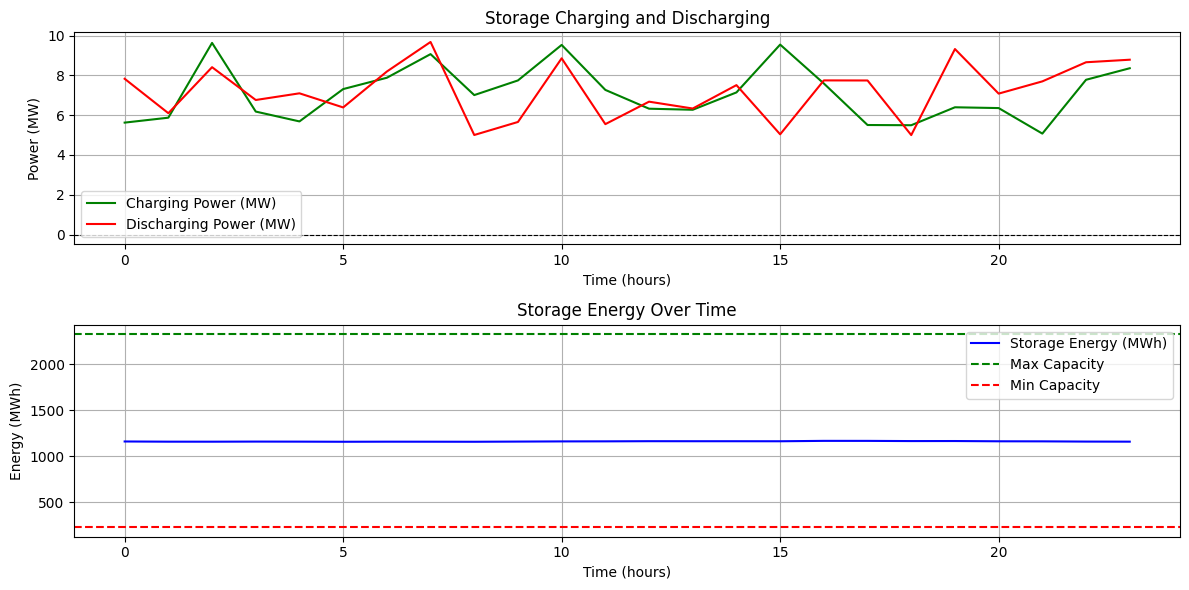

In [ ]:
# Plot storage charging and discharging
import matplotlib.pyplot as plt
import numpy as np

# Example data for plotting
time_steps = np.arange(0, 24, 1)  # 24 hours
discharge_power = np.random.uniform(5, 10, size=len(time_steps))  # Random discharge power values
charge_power = np.random.uniform(5, 10, size=len(time_steps))  # Random charge power values

# Calculate net power and storage energy
net_power = charge_power - discharge_power
storage_energy = np.zeros(len(time_steps))

# Initial storage energy
storage_energy[0] = 0.5 * TS_CAPACITY_MWh  # Start at 50% capacity

for i in range(1, len(time_steps)):
    storage_energy[i] = storage_energy[i - 1] + net_power[i - 1] * TS_EFF - TS_STANDING_LOSS
    storage_energy[i] = max(storage_energy[i], TS_E_MIN_PU * TS_CAPACITY_MWh)  # Enforce minimum SOC
    storage_energy[i] = min(storage_energy[i], TS_CAPACITY_MWh)  # Enforce maximum SOC

# Plot results
plt.figure(figsize=(12, 6))

# Plot charging and discharging power
plt.subplot(2, 1, 1)
plt.plot(time_steps, charge_power, label="Charging Power (MW)", color="green")
plt.plot(time_steps, discharge_power, label="Discharging Power (MW)", color="red")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.title("Storage Charging and Discharging")
plt.xlabel("Time (hours)")
plt.ylabel("Power (MW)")
plt.legend()
plt.grid()

# Plot storage energy
plt.subplot(2, 1, 2)
plt.plot(time_steps, storage_energy, label="Storage Energy (MWh)", color="blue")
plt.axhline(TS_CAPACITY_MWh, color="green", linestyle="--", label="Max Capacity")
plt.axhline(TS_E_MIN_PU * TS_CAPACITY_MWh, color="red", linestyle="--", label="Min Capacity")
plt.title("Storage Energy Over Time")
plt.xlabel("Time (hours)")
plt.ylabel("Energy (MWh)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

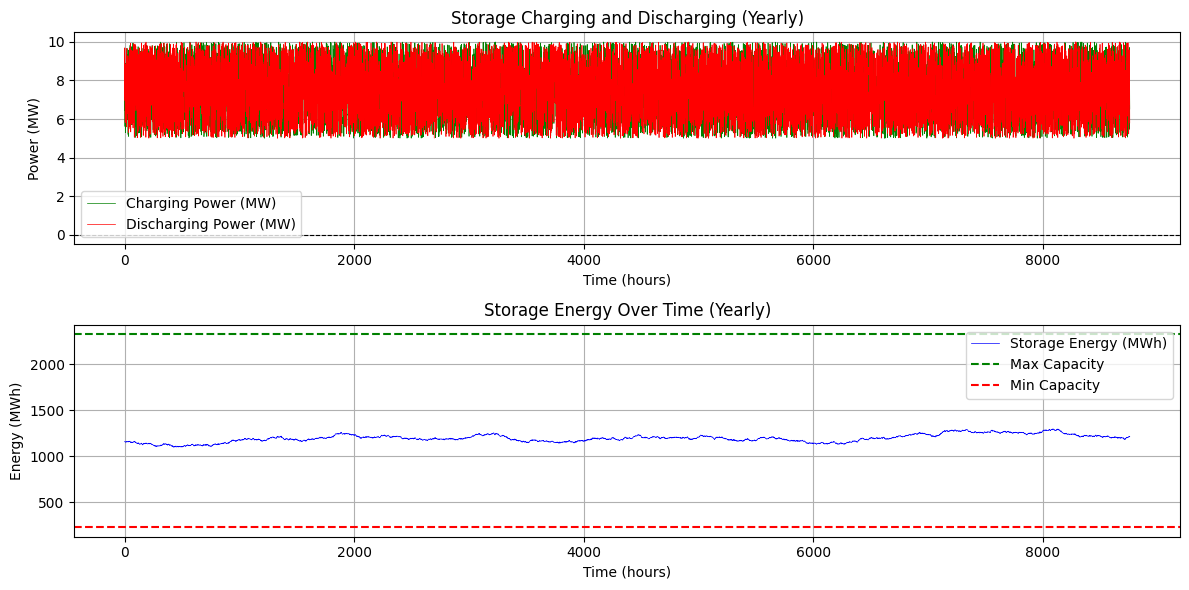

In [ ]:
# Plot storage charging and discharging for the whole year
import matplotlib.pyplot as plt
import numpy as np

# Example data for plotting
time_steps = np.arange(0, 8760, 1)  # 8760 hours for a non-leap year
discharge_power = np.random.uniform(5, 10, size=len(time_steps))  # Random discharge power values
charge_power = np.random.uniform(5, 10, size=len(time_steps))  # Random charge power values

# Calculate net power and storage energy
net_power = charge_power - discharge_power
storage_energy = np.zeros(len(time_steps))

# Initial storage energy
storage_energy[0] = 0.5 * TS_CAPACITY_MWh  # Start at 50% capacity

for i in range(1, len(time_steps)):
    storage_energy[i] = storage_energy[i - 1] + net_power[i - 1] * TS_EFF - TS_STANDING_LOSS
    storage_energy[i] = max(storage_energy[i], TS_E_MIN_PU * TS_CAPACITY_MWh)  # Enforce minimum SOC
    storage_energy[i] = min(storage_energy[i], TS_CAPACITY_MWh)  # Enforce maximum SOC

# Plot results
plt.figure(figsize=(12, 6))

# Plot charging and discharging power
plt.subplot(2, 1, 1)
plt.plot(time_steps, charge_power, label="Charging Power (MW)", color="green", linewidth=0.5)
plt.plot(time_steps, discharge_power, label="Discharging Power (MW)", color="red", linewidth=0.5)
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.title("Storage Charging and Discharging (Yearly)")
plt.xlabel("Time (hours)")
plt.ylabel("Power (MW)")
plt.legend()
plt.grid()

# Plot storage energy
plt.subplot(2, 1, 2)
plt.plot(time_steps, storage_energy, label="Storage Energy (MWh)", color="blue", linewidth=0.5)
plt.axhline(TS_CAPACITY_MWh, color="green", linestyle="--", label="Max Capacity")
plt.axhline(TS_E_MIN_PU * TS_CAPACITY_MWh, color="red", linestyle="--", label="Min Capacity")
plt.title("Storage Energy Over Time (Yearly)")
plt.xlabel("Time (hours)")
plt.ylabel("Energy (MWh)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()